In [1]:
import torch
import pickle 
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import matplotlib as mpl
import copy
import sys
import matplotlib as mpl
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter, binary_opening, binary_closing


# Get the parent directory of the current directory
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)
    
from diffusion_proc import Diffusion, linear_noise_schedule
from unet import Unet
from dataset import CondSeqImageDataset
from baseline_cnn import Wildfire_CNN

VOL_PATH = "/vol/bitbucket/ag323"

In [6]:
DATA_DIR = os.path.join(VOL_PATH, "diss_ag/data/evaluation_data") #"C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/data/evaluation_data"
MODEL_PATH = os.path.join(VOL_PATH, "diss_ag/results/ckpts/gde_ensemble_model_4_64x64_simData_10000samples_fixedParams.pt")
BASELINE_PATH = os.path.join(VOL_PATH, "diss_ag/results/ckpts/baseline_cnn_64x64_simData100samples.pt")# "C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/results/ckpts/gde_ensemble_model_4_64x64_simData_10000samples_fixedParams.pt"

(64, 64)


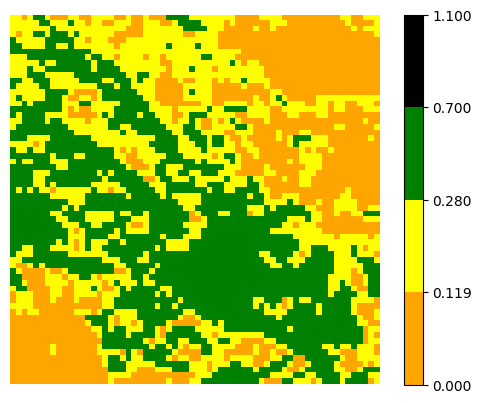

In [3]:
# custormize colorbar
cmap = mpl.colors.ListedColormap(['orange','yellow', 'green', 'black'])
cmap.set_over('0.25')
cmap.set_under('0.75')
bounds =  [0.0,0.1188,0.2798,0.7,1.1] #[0.0,0.2488,0.3098,0.7,1.1] # [1.0, 2.02, 2.27, 3.5, 5.1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

BACKGROUND_PATH = os.path.join(VOL_PATH, "diss_ag/data/background.mpy") # "C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/
with open(BACKGROUND_PATH, 'rb') as f:
    background_img = pickle.load(f)
    print(background_img.shape)

plt.imshow(background_img, cmap=cmap, norm=norm)
plt.colorbar()
plt.axis("off")
plt.show()

# binary custom cmap
binary_cmap = mpl.colors.ListedColormap(['blue', 'black', 'red'])

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
diff_model =  Unet(
    in_ch=1,
    cond_ch=1,
    model_ch=96,
    output_ch=1,
    channel_mult=(1, 2, 2),
    attn_res=[],
)
diff_model.load_state_dict(torch.load(MODEL_PATH))
diff_model.to(device)

Unet(
  (time_emb): Sequential(
    (0): Linear(in_features=96, out_features=384, bias=True)
    (1): SiLU()
    (2): Linear(in_features=384, out_features=384, bias=True)
  )
  (downsample_blocks): ModuleList(
    (0): TimestepSeqEmbedding(
      (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepSeqEmbedding(
      (0): ResBlock(
        (conv_1): Sequential(
          (0): GroupNorm(32, 96, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (time_embedding): Sequential(
          (0): SiLU()
          (1): Linear(in_features=384, out_features=96, bias=True)
        )
        (condition_conv): Sequential(
          (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): SiLU()
        )
        (conv_2): Sequential(
          (0): GroupNorm(32, 96, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(

In [7]:
baseline_model = Wildfire_CNN()
baseline_model.load_state_dict(torch.load(BASELINE_PATH))
baseline_model.to(device)

Wildfire_CNN(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bottleneck): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU(inpl

In [8]:
transform = transforms.Compose([
    transforms.ToTensor()
])

simulated_data = CondSeqImageDataset(DATA_DIR, transform=transform)

In [62]:
binary_cmap = mpl.colors.ListedColormap(['blue', 'black', 'red'])
under_cmap = mpl.colors.ListedColormap(['blue', 'black'])
over_cmap = mpl.colors.ListedColormap(['black', 'red'])

def plot_images_in_row(images, starting_image=None, type_output="simulation", mismatch_stat=None):
    """
    Function to plot 5 images in a single row, side by side.

    Parameters:
    - images: List or array of 5 images to be plotted.
    - starting_image: An optional starting image to be displayed in the first subplot.
    """

    # Ensure the input images are in a list or array and exactly 5 images
    assert len(images) == 4, "The images array must contain exactly 4 images."
    
    # Create a figure with a grid layout with 1 row and 6 columns
    fig, axes = plt.subplots(1, 4, figsize=(12, 6))

    # # Plot the starting image if provided
    # if starting_image is not None:
    #     if type_output != "mismatch":
    #         start_img = starting_image.cpu().squeeze().squeeze()
    #         combined_img = np.where(start_img == 1, 1, background_img)
    #         axes[0].imshow(combined_img, cmap=cmap, interpolation="none", norm=norm)
    #         axes[0].set_title('Starting State t=0')
    #         axes[0].axis('off')
    #     else:
    #         axes[0].imshow(starting_image.cpu().squeeze().squeeze(), cmap="binary_r")
    #         axes[0].set_title('Starting State t=0')
    #         axes[0].axis('off')
    # else:
    #     axes[0].axis('off')  # Hide the first subplot if no starting image is provided

    # Plot the 5 images
    for i in range(4):
        if "mismatch" not in type_output:
            img = images[i]
            combined_img = np.where(img == 1, 1, background_img)
            axes[i].imshow(combined_img, cmap=cmap, interpolation="none", norm=norm)
            if type_output=="simulation":
                axes[i].set_title(f'Simulated t = {(i+1) * 5}')
            elif type_output=="predicted (diffusion)":
                axes[i].set_title(f'Diffusion Predicted t = {(i+1) * 5}')
            elif type_output=="predicted (cnn)":
                axes[i].set_title(f'Baseline Predicted t = {(i+1) * 5}')
            axes[i].axis('off')
        else:
            img = images[i]
            over_perc, under_perc, total_mismatch = mismatch_stat[i]
            print(np.unique(img))
            if len(np.unique(img)) == 3:
                axes[i].imshow(img, cmap=binary_cmap)
            elif np.array_equal(np.unique(img), [-1, 0]):
                axes[i].imshow(img, cmap=under_cmap)
            elif np.array_equal(np.unique(img), [0, 1]):
                axes[i].imshow(img, cmap=over_cmap)
                
            if type_output == "mismatch (cnn)":
                axes[i].set_title(f'Mismatch')
            elif type_output == "mismatch (diffusion)":
                axes[i].set_title(f'Mismatch')
            axes[i].axis('off')

    # Adjust the layout
    plt.tight_layout()
    plt.show()
    

In [35]:
diffusion = Diffusion(timesteps=500, noise_schedule='linear')

def generate_predictions(t_0, diff_client, num_preds=4):
    
    input_img = t_0

    input_img = input_img.to(device).float().unsqueeze(0)
    image_size = input_img.shape[-1]
    channels = input_img.shape[1]

    input_arr = [input_img]
    outputs = []
    for i in range(num_preds):
        generated_images = diff_client.sample(
            model=diff_model,
            image_size=image_size,
            cond_img=input_arr[-1],
            batch_size=1,  # Set the desired batch size
            channels=channels,
            w=2,
            clip_denoised=True
        )
        otpt = generated_images[-1].squeeze().squeeze()
        otpt = np.where(otpt <= 0.5, 0, otpt)
        otpt = np.where(otpt > 0.5, 1, otpt)
        
        outputs.append(otpt)
        
        
        next_input = transform(otpt).to(device).float().unsqueeze(0)
        input_arr.append(next_input)

    return outputs
def generate_baseline_preds(t_0, num_preds=4):
    input_img = t_0

    # Prepare the input image for the CNN
    input_img = input_img.to(device).float().unsqueeze(0)
    input_arr = [input_img]
    outputs = []
    
    for i in range(num_preds):
        # Get the prediction from the CNN model
        with torch.no_grad():
            generated_image = baseline_model(input_arr[-1])

        # Apply thresholding
        generated_image = torch.where(generated_image > 0.5, torch.tensor(1.0).to(device), torch.tensor(0.0).to(device))
        
        # Prepare the output image for storing
        otpt = generated_image.squeeze().cpu().numpy()
        
        outputs.append(otpt)
        
        # Transform the output back to input format for the next iteration
        next_input = torch.tensor(otpt).to(device).float().unsqueeze(0).unsqueeze(0)  # Adjust dimensions as needed
        input_arr.append(next_input)

    return outputs
    
def compute_pixel_mismatch(image1, image2):
    """
    Compute the pixel mismatch between two binary images and return a binary image representing the mismatch.

    Parameters:
    - image1: numpy array representing the first binary image.
    - image2: numpy array representing the second binary image.

    Returns:
    - mismatch_image: A binary image where mismatched pixels are 1 and matching pixels are 0.
    - mismatch_percentage: The percentage of mismatched pixels.
    - over_under_estimate: An image where:
        - 1 represents overestimated pixels (present in image1 but not in image2),
        - -1 represents underestimated pixels (present in image2 but not in image1),
        - 0 represents matching pixels.
    """
    # Convert torch tensors to numpy arrays if needed
    if isinstance(image1, torch.Tensor):
        image1 = image1.numpy()
    if isinstance(image2, torch.Tensor):
        image2 = image2.numpy()
        
    # Ensure both images have the same shape
    if image1.shape != image2.shape:
        raise ValueError("The two images must have the same dimensions.")
    
    # Compute the mismatch by comparing the images
    mismatch_image = (image1 != image2).astype(int)  # Convert boolean array to integer array
    
    # Calculate the percentage of mismatched pixels
    total_pixels = image1.size
    mismatched_pixels = np.sum(mismatch_image)
    mismatch_percentage = round((mismatched_pixels / total_pixels) * 100, 3)
    
    # Create over_under_estimate image
    over_under_estimate = np.zeros_like(image1, dtype=int)
    
    # Label overestimated pixels as 1 (present in image1 but not in image2)
    over_under_estimate[(image1 == 1) & (image2 == 0)] = 1
    
    # Label underestimated pixels as -1 (present in image2 but not in image1)
    over_under_estimate[(image1 == 0) & (image2 == 1)] = -1

    # Calculate the percentages
    overestimated_pixels = np.sum(over_under_estimate == 1)
    underestimated_pixels = np.sum(over_under_estimate == -1)
    overestimate_percentage = round((overestimated_pixels / total_pixels) * 100, 3)
    underestimate_percentage = round((underestimated_pixels / total_pixels) * 100, 3)
    
    return mismatch_image, over_under_estimate, overestimate_percentage, underestimate_percentage, mismatch_percentage


0 16


sampling loop time step: 100%|████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 41.02it/s]


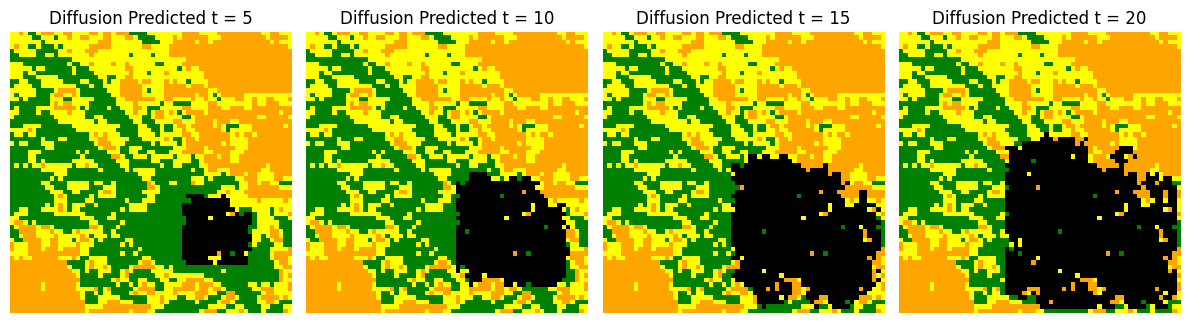

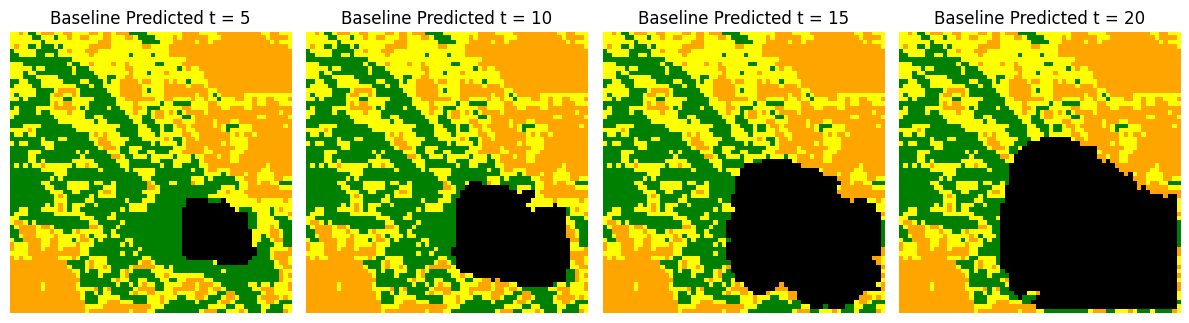

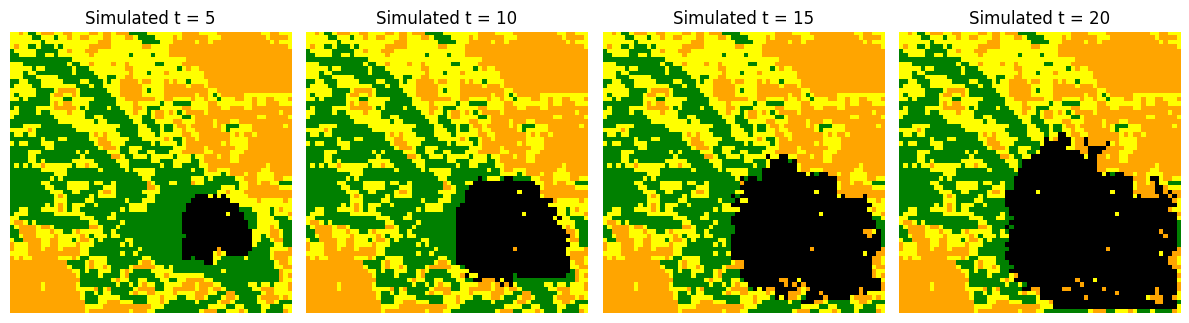

Diffusion - Overestimate: 0.757% | Underestimate: 0.366%, Total Mismatch: 1.123%
Diffusion - Overestimate: 1.587% | Underestimate: 0.586%, Total Mismatch: 2.173%
Diffusion - Overestimate: 3.003% | Underestimate: 1.001%, Total Mismatch: 4.004%
Diffusion - Overestimate: 3.979% | Underestimate: 2.148%, Total Mismatch: 6.128%
[-1  0  1]
[-1  0  1]
[-1  0  1]
[-1  0  1]


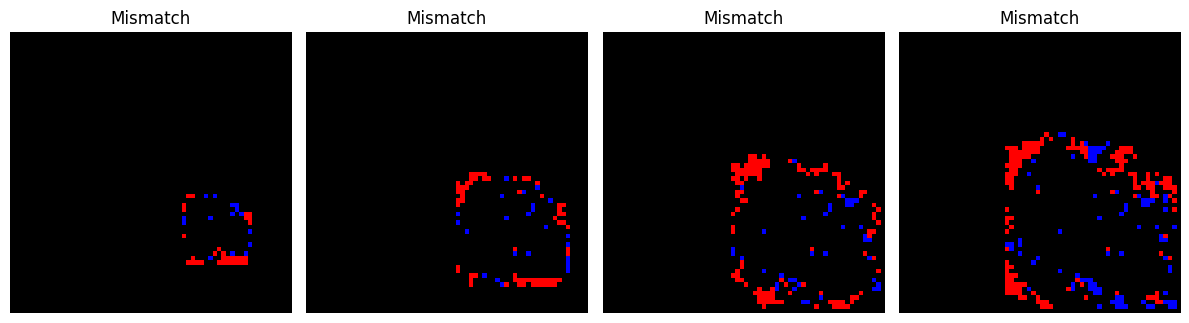

CNN - Overestimate: 0.732% | Underestimate: 0.366%, Total Mismatch: 1.099%
CNN - Overestimate: 1.27% | Underestimate: 1.05%, Total Mismatch: 2.319%
CNN - Overestimate: 3.223% | Underestimate: 0.464%, Total Mismatch: 3.687%
CNN - Overestimate: 3.857% | Underestimate: 0.415%, Total Mismatch: 4.272%
[-1  0  1]
[-1  0  1]
[-1  0  1]
[-1  0  1]


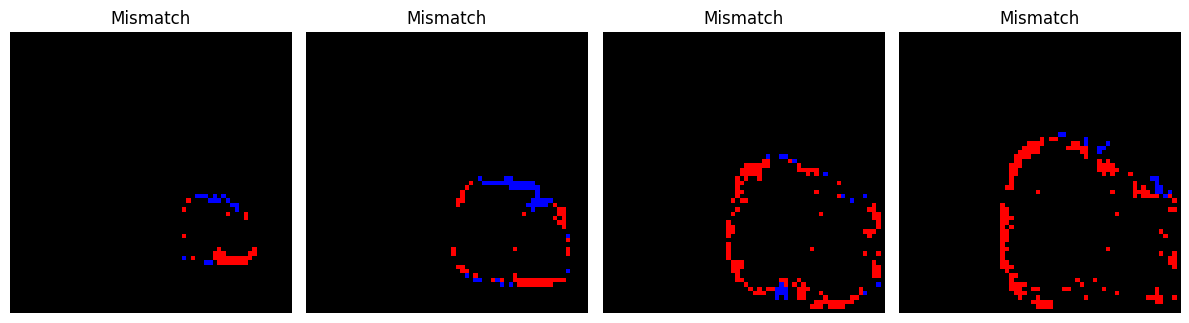

16 32


sampling loop time step: 100%|████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 41.01it/s]


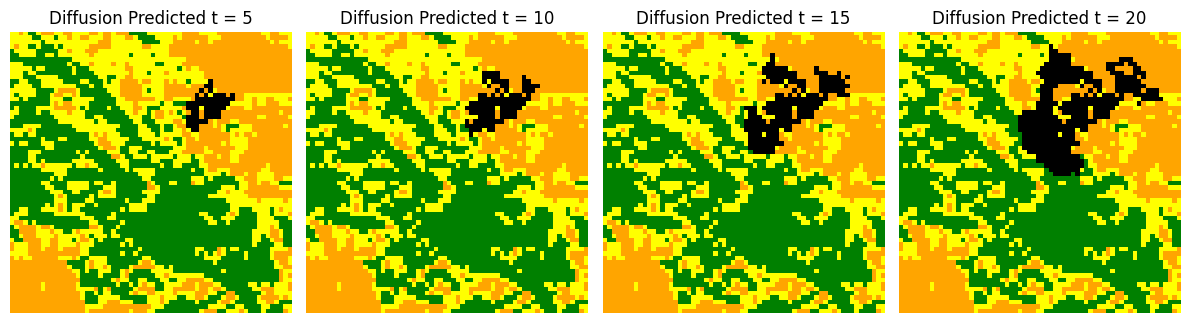

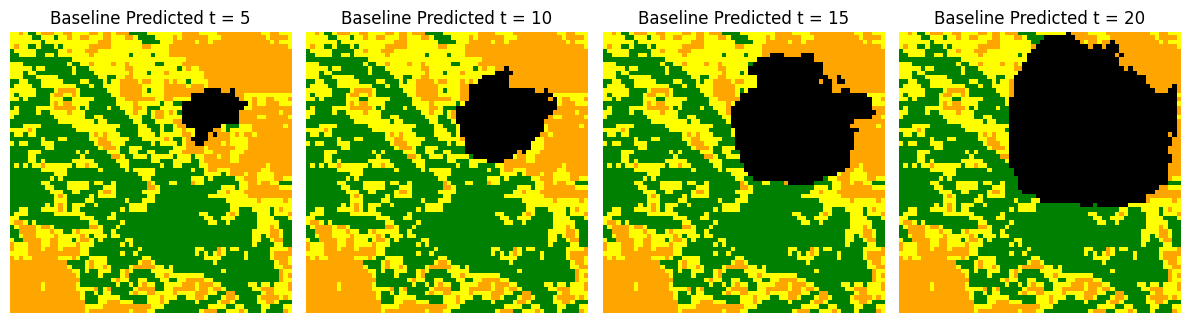

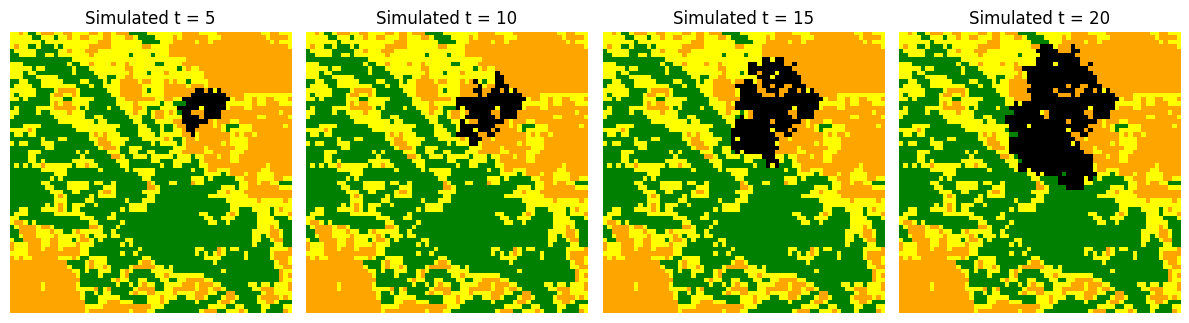

Diffusion - Overestimate: 0.22% | Underestimate: 0.391%, Total Mismatch: 0.61%
Diffusion - Overestimate: 0.708% | Underestimate: 0.977%, Total Mismatch: 1.685%
Diffusion - Overestimate: 1.27% | Underestimate: 2.783%, Total Mismatch: 4.053%
Diffusion - Overestimate: 1.88% | Underestimate: 4.224%, Total Mismatch: 6.104%
[-1  0  1]
[-1  0  1]
[-1  0  1]
[-1  0  1]


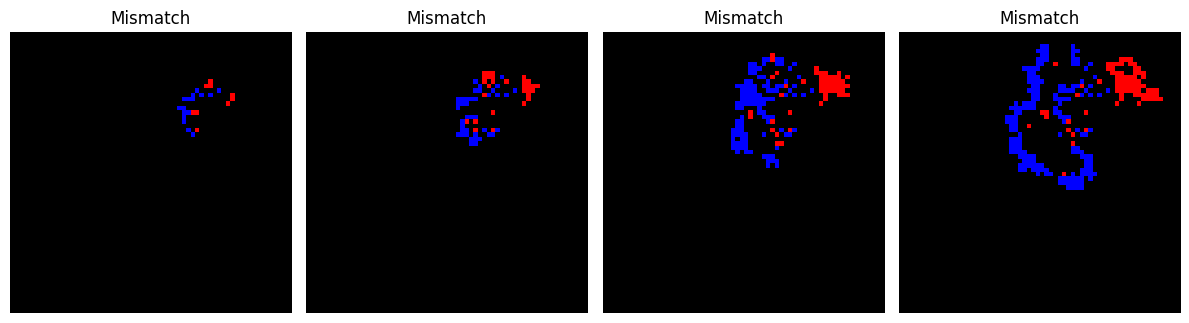

CNN - Overestimate: 1.367% | Underestimate: 0.195%, Total Mismatch: 1.562%
CNN - Overestimate: 4.883% | Underestimate: 0.171%, Total Mismatch: 5.054%
CNN - Overestimate: 10.522% | Underestimate: 0.391%, Total Mismatch: 10.913%
CNN - Overestimate: 17.505% | Underestimate: 0.049%, Total Mismatch: 17.554%
[-1  0  1]
[-1  0  1]
[-1  0  1]
[-1  0  1]


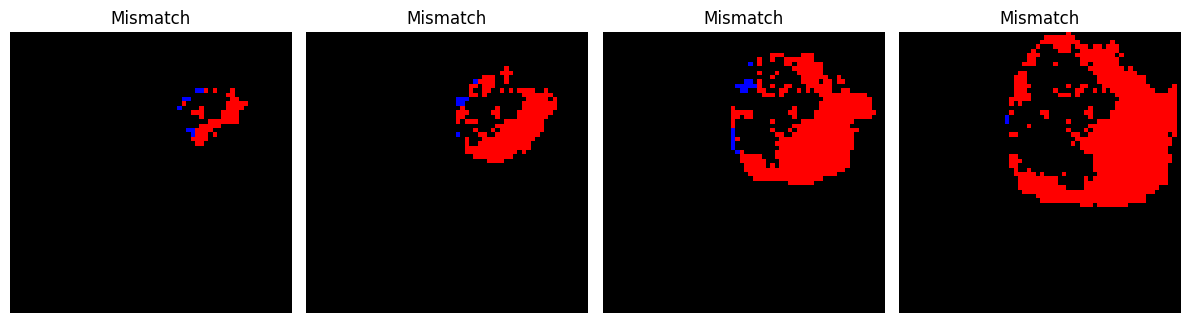

32 48


sampling loop time step: 100%|████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 41.22it/s]


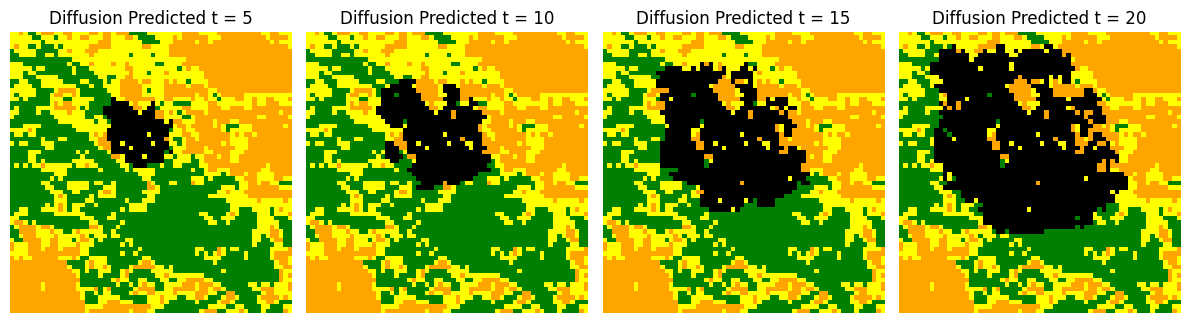

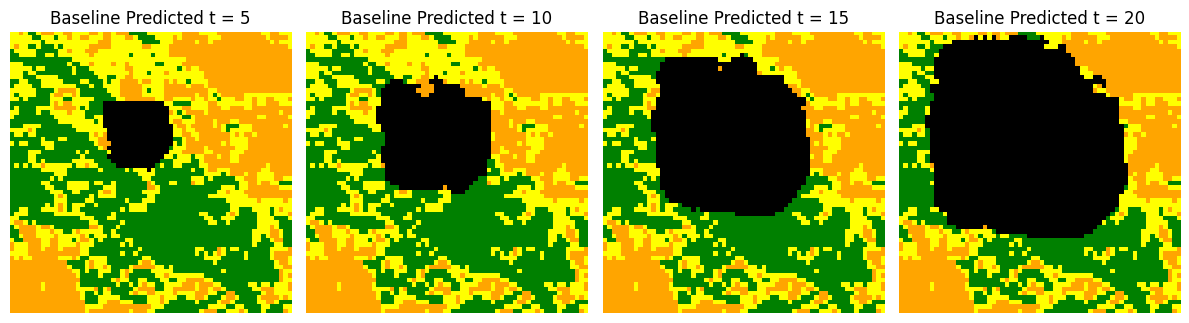

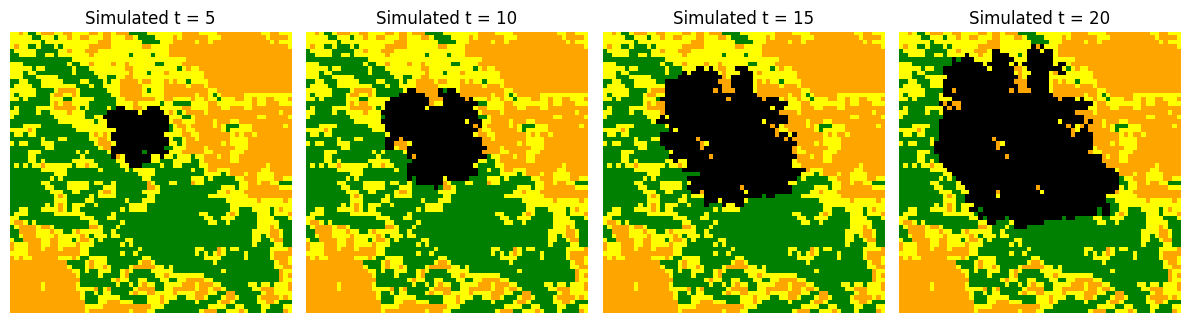

Diffusion - Overestimate: 0.708% | Underestimate: 0.464%, Total Mismatch: 1.172%
Diffusion - Overestimate: 1.66% | Underestimate: 1.172%, Total Mismatch: 2.832%
Diffusion - Overestimate: 3.149% | Underestimate: 2.124%, Total Mismatch: 5.273%
Diffusion - Overestimate: 5.64% | Underestimate: 2.515%, Total Mismatch: 8.154%
[-1  0  1]
[-1  0  1]
[-1  0  1]
[-1  0  1]


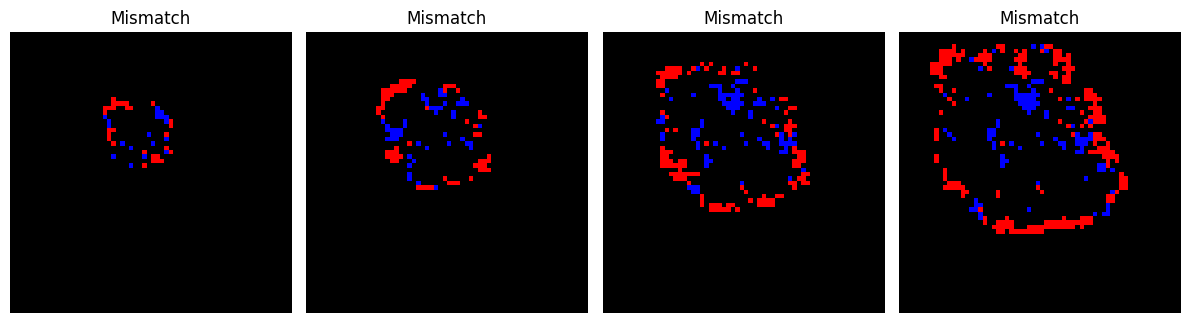

CNN - Overestimate: 1.465% | Underestimate: 0.0%, Total Mismatch: 1.465%
CNN - Overestimate: 4.541% | Underestimate: 0.024%, Total Mismatch: 4.565%
CNN - Overestimate: 9.644% | Underestimate: 0.0%, Total Mismatch: 9.644%
CNN - Overestimate: 14.526% | Underestimate: 0.0%, Total Mismatch: 14.526%
[0 1]
[-1  0  1]
[0 1]
[0 1]


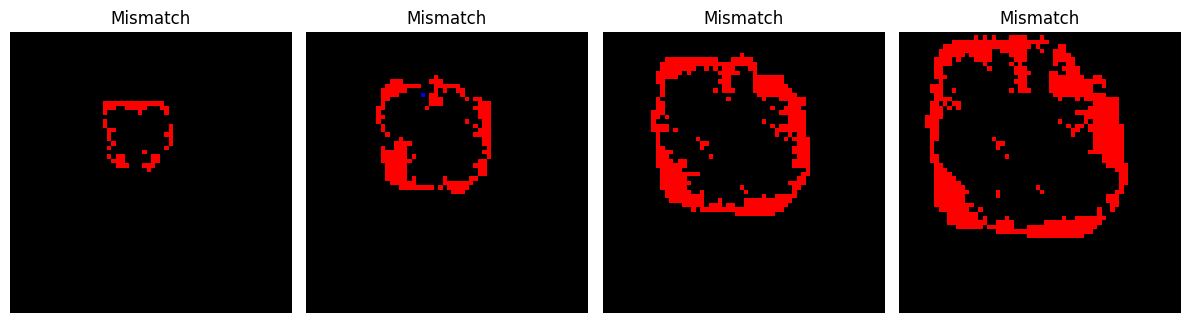

48 64


sampling loop time step: 100%|████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 41.35it/s]


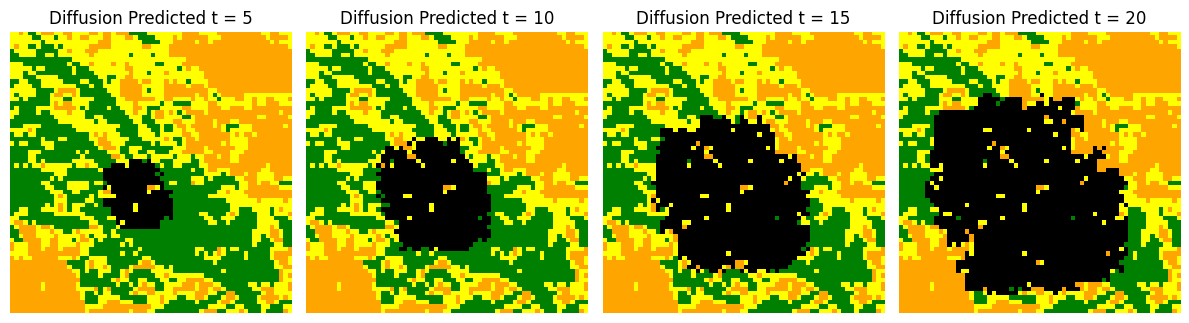

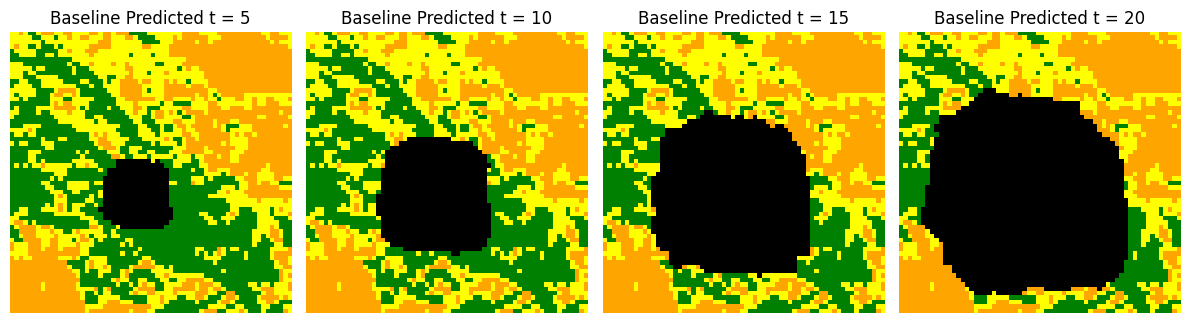

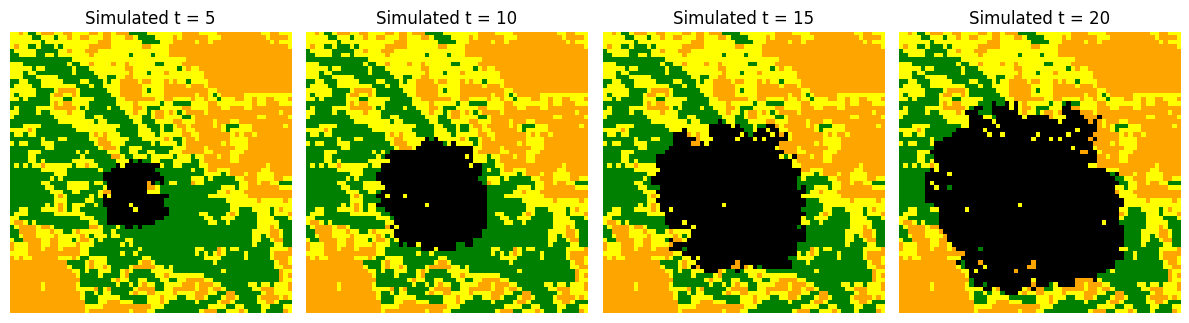

Diffusion - Overestimate: 0.781% | Underestimate: 0.366%, Total Mismatch: 1.147%
Diffusion - Overestimate: 1.294% | Underestimate: 1.001%, Total Mismatch: 2.295%
Diffusion - Overestimate: 3.223% | Underestimate: 1.538%, Total Mismatch: 4.761%
Diffusion - Overestimate: 5.078% | Underestimate: 2.71%, Total Mismatch: 7.788%
[-1  0  1]
[-1  0  1]
[-1  0  1]
[-1  0  1]


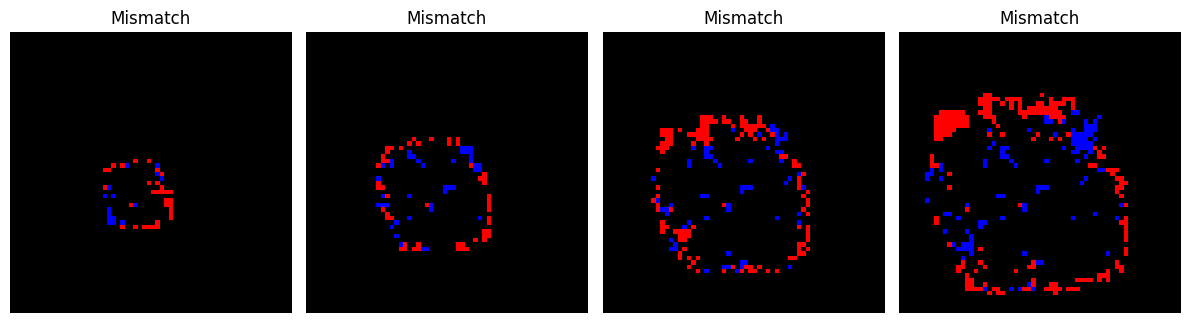

CNN - Overestimate: 1.367% | Underestimate: 0.049%, Total Mismatch: 1.416%
CNN - Overestimate: 2.637% | Underestimate: 0.073%, Total Mismatch: 2.71%
CNN - Overestimate: 6.152% | Underestimate: 0.122%, Total Mismatch: 6.274%
CNN - Overestimate: 8.496% | Underestimate: 0.146%, Total Mismatch: 8.643%
[-1  0  1]
[-1  0  1]
[-1  0  1]
[-1  0  1]


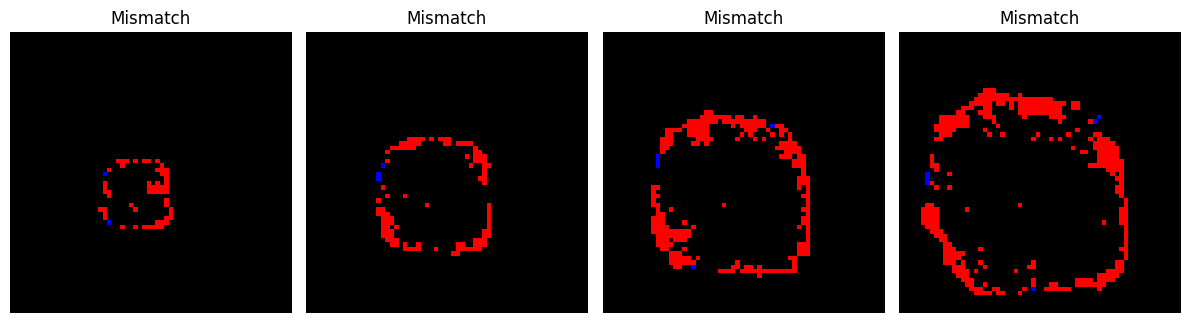

64 80


sampling loop time step: 100%|████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 41.18it/s]


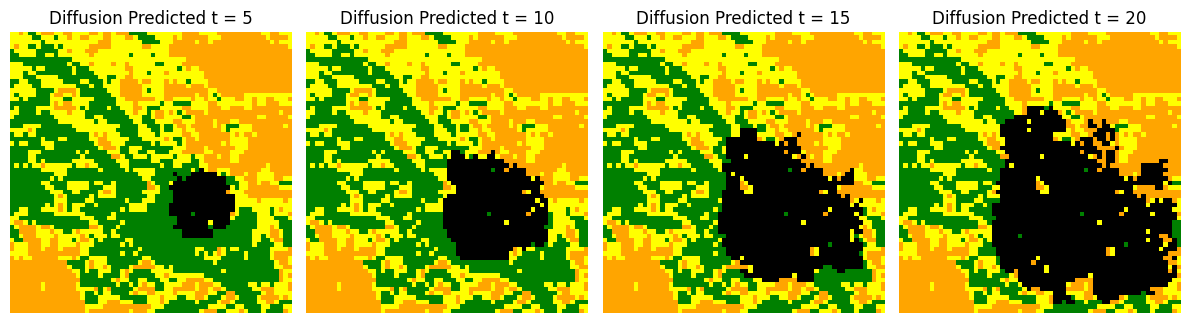

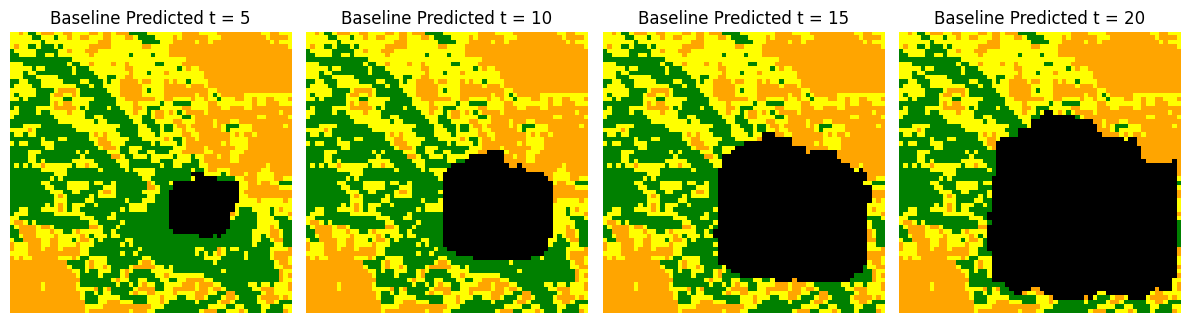

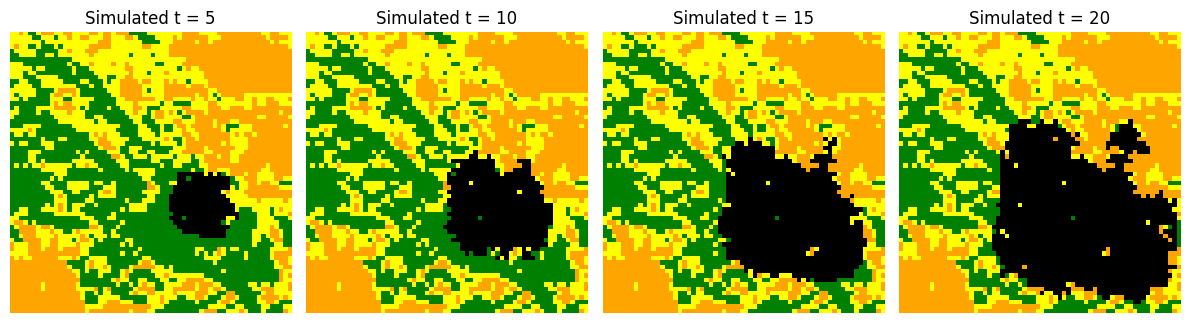

Diffusion - Overestimate: 0.513% | Underestimate: 0.61%, Total Mismatch: 1.123%
Diffusion - Overestimate: 1.465% | Underestimate: 0.952%, Total Mismatch: 2.417%
Diffusion - Overestimate: 2.393% | Underestimate: 2.148%, Total Mismatch: 4.541%
Diffusion - Overestimate: 4.297% | Underestimate: 3.564%, Total Mismatch: 7.861%
[-1  0  1]
[-1  0  1]
[-1  0  1]
[-1  0  1]


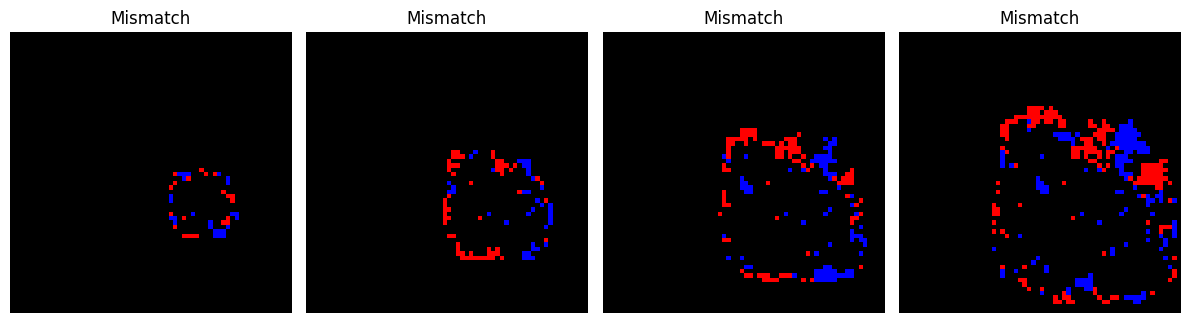

CNN - Overestimate: 0.61% | Underestimate: 0.391%, Total Mismatch: 1.001%
CNN - Overestimate: 2.588% | Underestimate: 0.269%, Total Mismatch: 2.856%
CNN - Overestimate: 5.2% | Underestimate: 0.244%, Total Mismatch: 5.444%
CNN - Overestimate: 7.788% | Underestimate: 1.001%, Total Mismatch: 8.789%
[-1  0  1]
[-1  0  1]
[-1  0  1]
[-1  0  1]


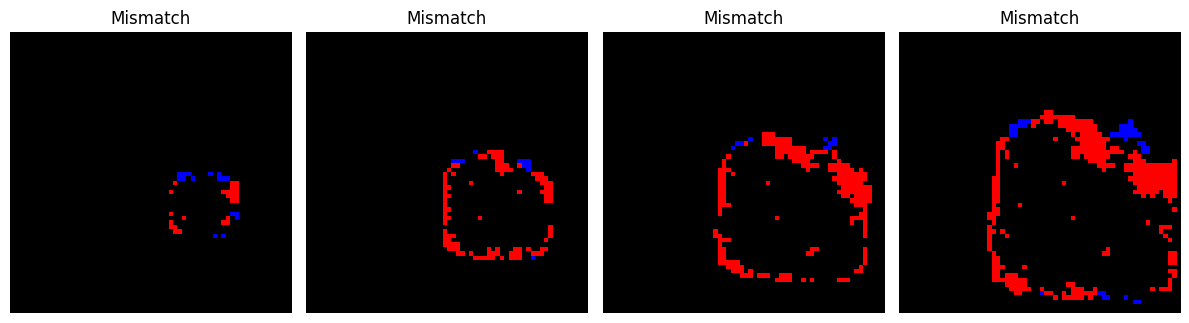

80 96


sampling loop time step: 100%|████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 41.04it/s]


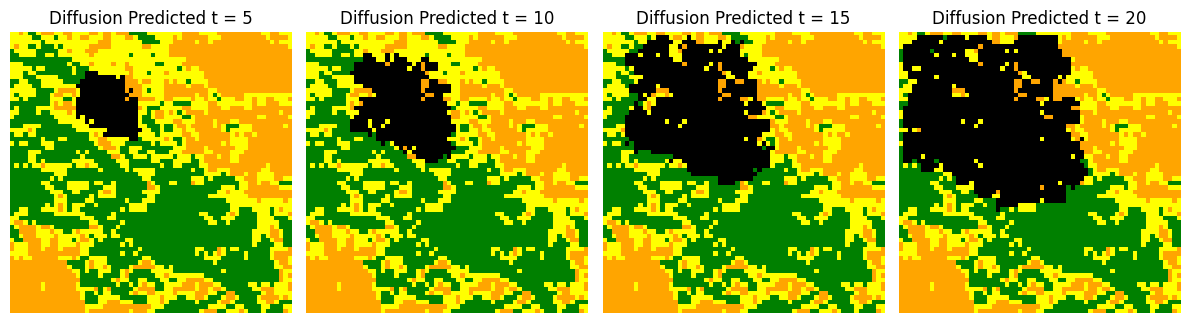

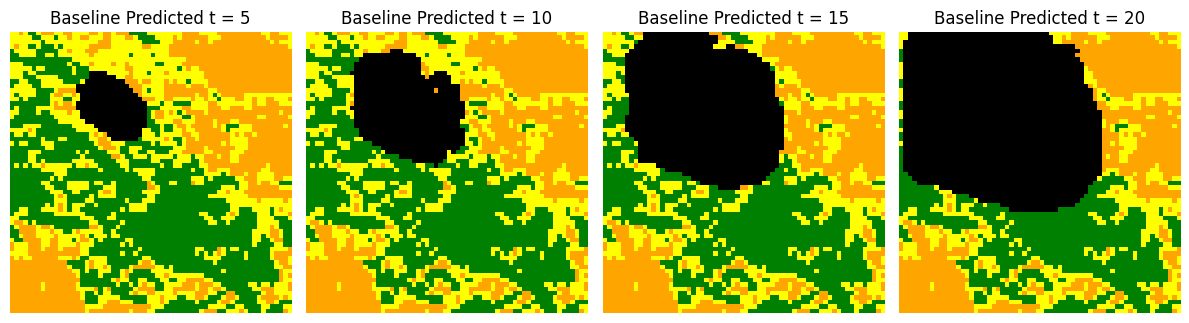

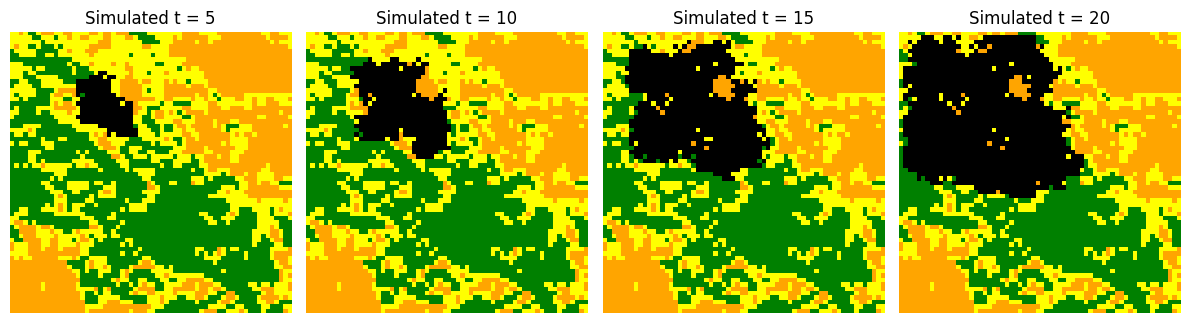

Diffusion - Overestimate: 0.952% | Underestimate: 0.195%, Total Mismatch: 1.147%
Diffusion - Overestimate: 2.246% | Underestimate: 0.781%, Total Mismatch: 3.027%
Diffusion - Overestimate: 3.784% | Underestimate: 2.051%, Total Mismatch: 5.835%
Diffusion - Overestimate: 4.834% | Underestimate: 2.563%, Total Mismatch: 7.397%
[-1  0  1]
[-1  0  1]
[-1  0  1]
[-1  0  1]


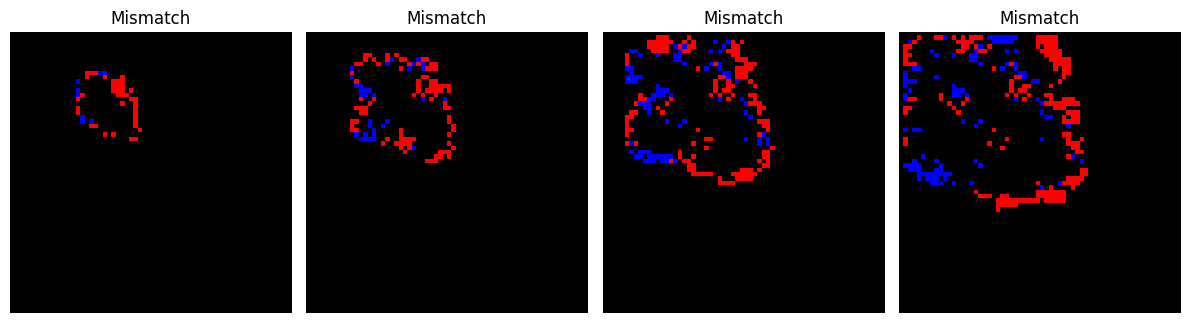

CNN - Overestimate: 1.392% | Underestimate: 0.122%, Total Mismatch: 1.514%
CNN - Overestimate: 4.541% | Underestimate: 0.195%, Total Mismatch: 4.736%
CNN - Overestimate: 8.862% | Underestimate: 0.269%, Total Mismatch: 9.131%
CNN - Overestimate: 11.719% | Underestimate: 0.0%, Total Mismatch: 11.719%
[-1  0  1]
[-1  0  1]
[-1  0  1]
[0 1]


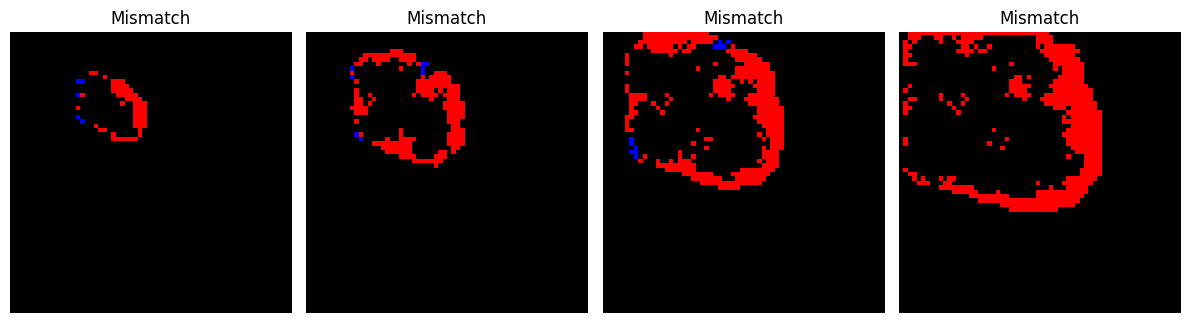

96 112


sampling loop time step: 100%|████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 40.71it/s]


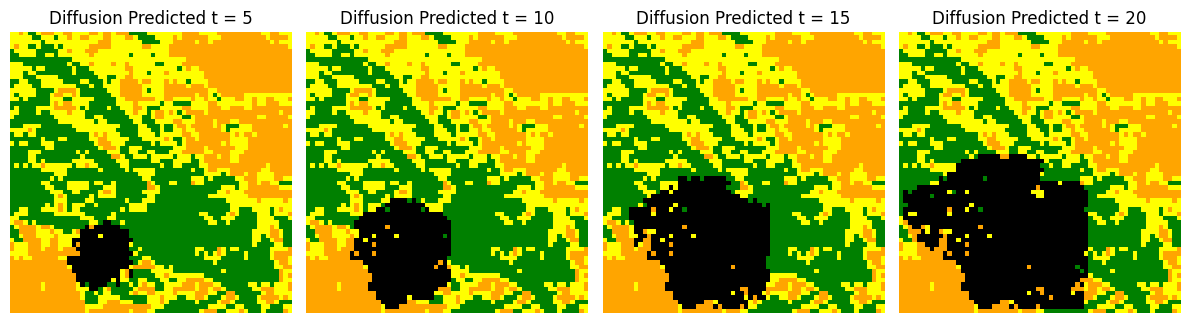

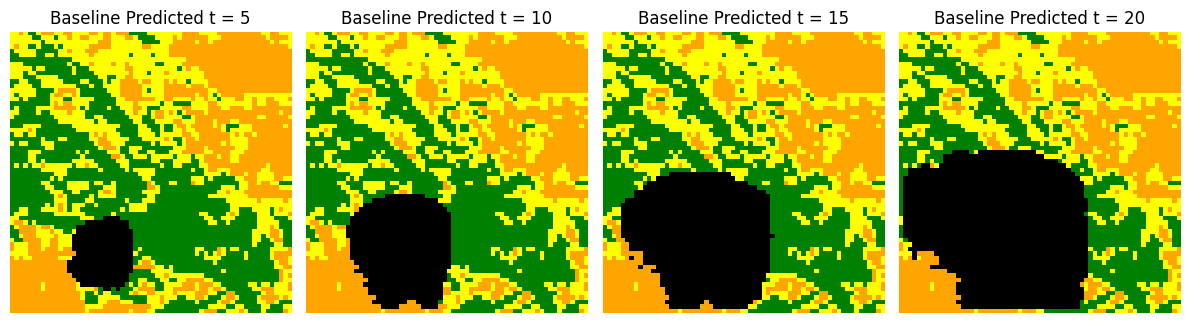

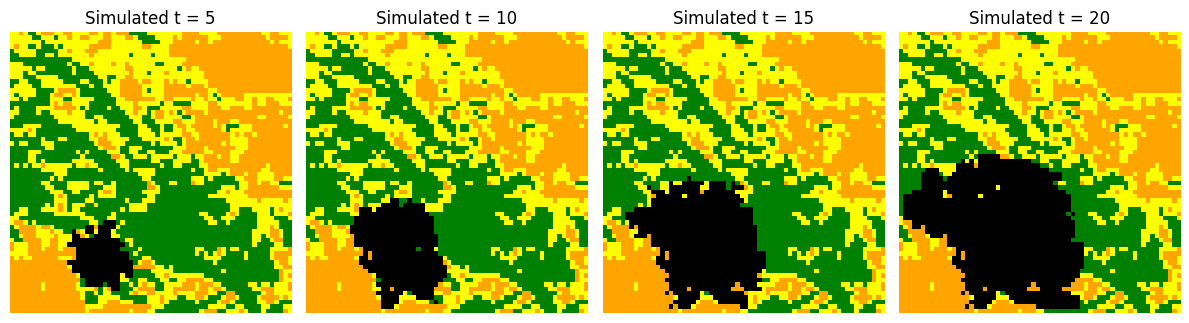

Diffusion - Overestimate: 0.757% | Underestimate: 0.464%, Total Mismatch: 1.221%
Diffusion - Overestimate: 1.807% | Underestimate: 0.61%, Total Mismatch: 2.417%
Diffusion - Overestimate: 2.783% | Underestimate: 1.05%, Total Mismatch: 3.833%
Diffusion - Overestimate: 3.247% | Underestimate: 1.709%, Total Mismatch: 4.956%
[-1  0  1]
[-1  0  1]
[-1  0  1]
[-1  0  1]


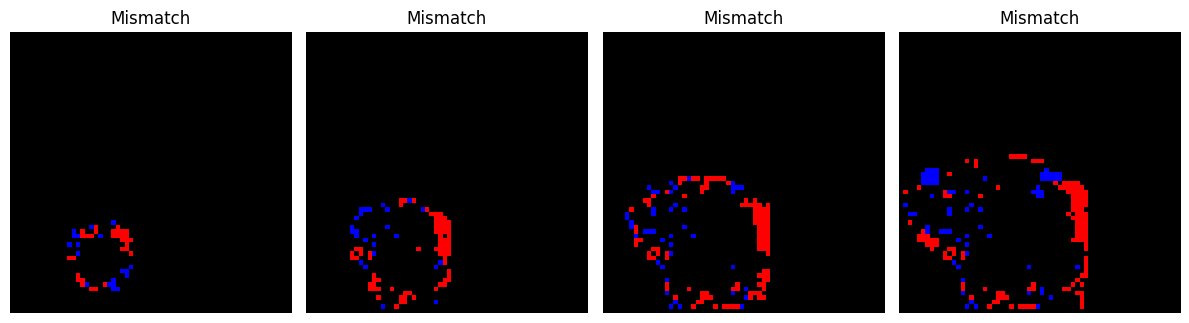

CNN - Overestimate: 1.44% | Underestimate: 0.098%, Total Mismatch: 1.538%
CNN - Overestimate: 3.564% | Underestimate: 0.0%, Total Mismatch: 3.564%
CNN - Overestimate: 6.03% | Underestimate: 0.0%, Total Mismatch: 6.03%
CNN - Overestimate: 7.202% | Underestimate: 0.0%, Total Mismatch: 7.202%
[-1  0  1]
[0 1]
[0 1]
[0 1]


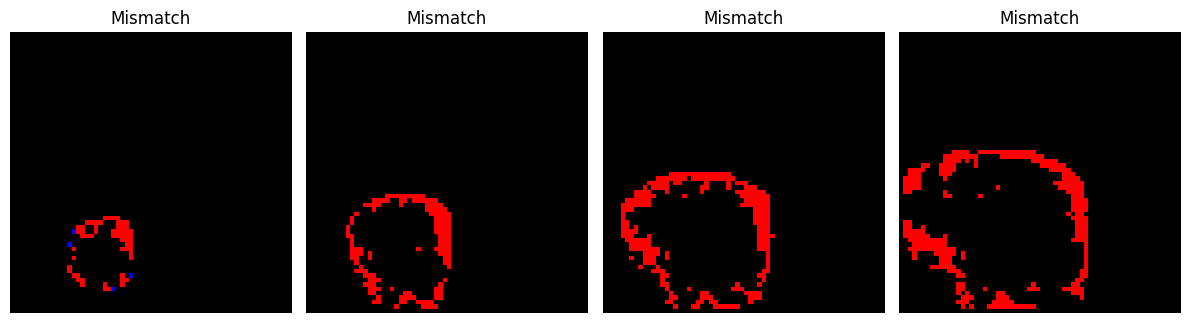

112 128


sampling loop time step: 100%|████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 40.77it/s]


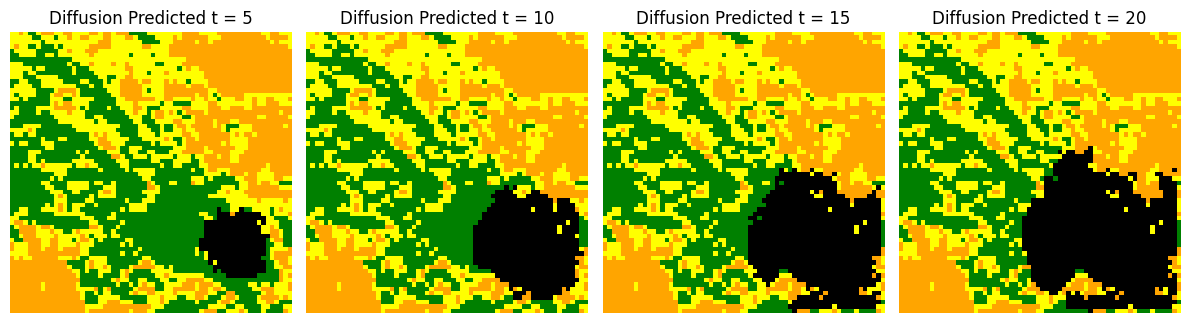

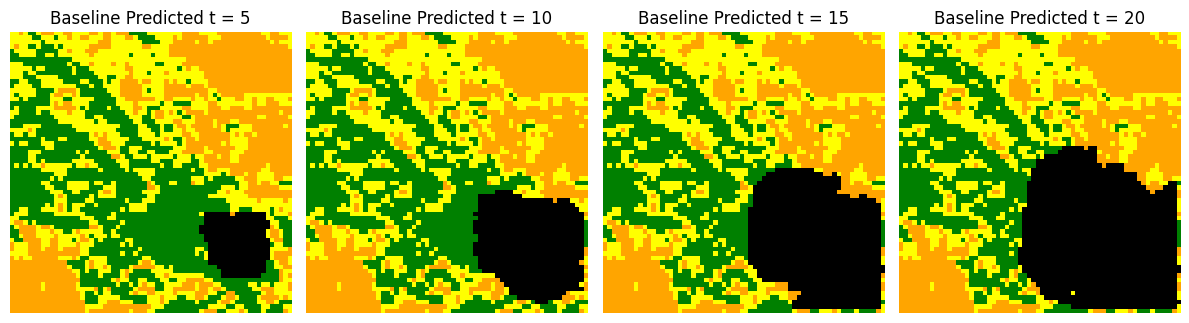

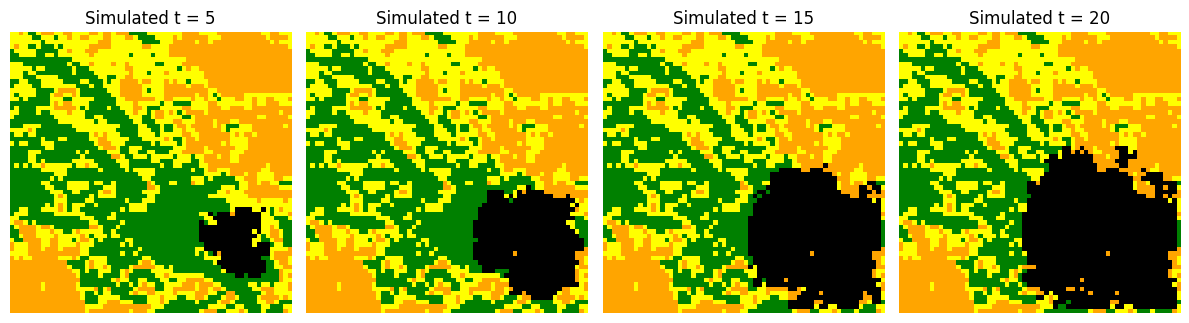

Diffusion - Overestimate: 0.708% | Underestimate: 0.366%, Total Mismatch: 1.074%
Diffusion - Overestimate: 0.879% | Underestimate: 0.952%, Total Mismatch: 1.831%
Diffusion - Overestimate: 0.732% | Underestimate: 2.197%, Total Mismatch: 2.93%
Diffusion - Overestimate: 0.708% | Underestimate: 3.491%, Total Mismatch: 4.199%
[-1  0  1]
[-1  0  1]
[-1  0  1]
[-1  0  1]


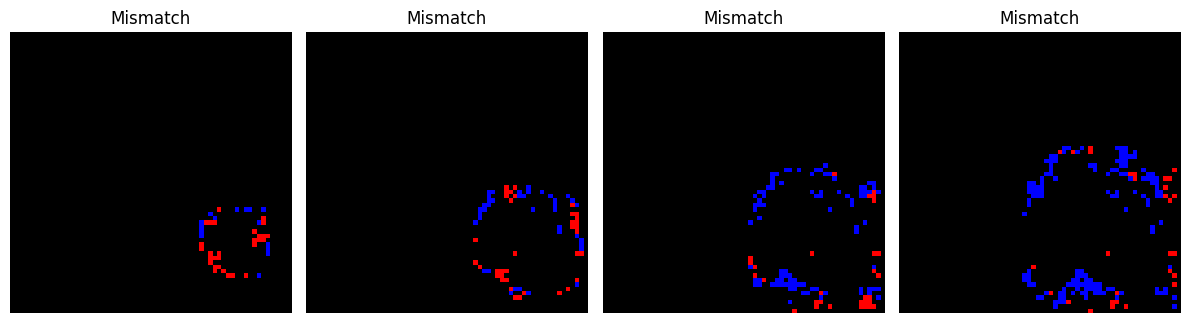

CNN - Overestimate: 0.903% | Underestimate: 0.244%, Total Mismatch: 1.147%
CNN - Overestimate: 1.636% | Underestimate: 0.513%, Total Mismatch: 2.148%
CNN - Overestimate: 1.489% | Underestimate: 0.708%, Total Mismatch: 2.197%
CNN - Overestimate: 2.368% | Underestimate: 1.001%, Total Mismatch: 3.369%
[-1  0  1]
[-1  0  1]
[-1  0  1]
[-1  0  1]


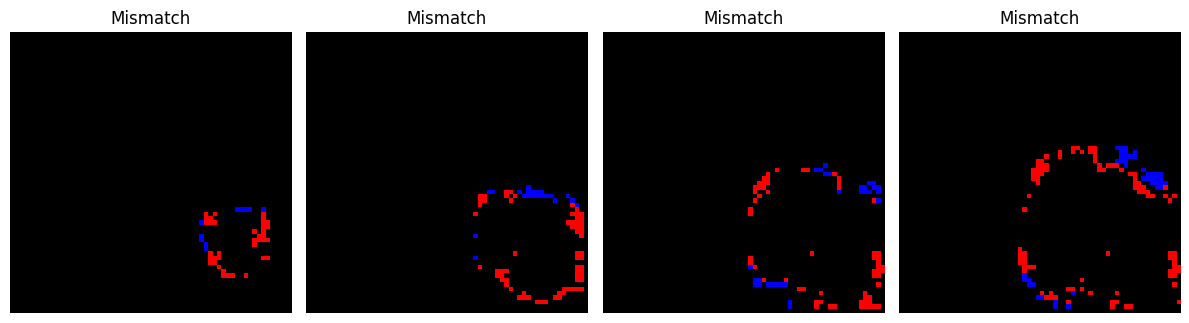

128 144


sampling loop time step: 100%|████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 41.19it/s]


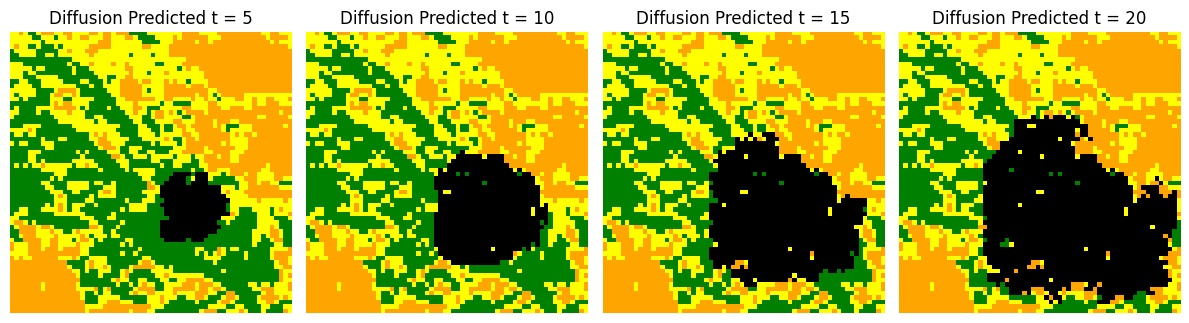

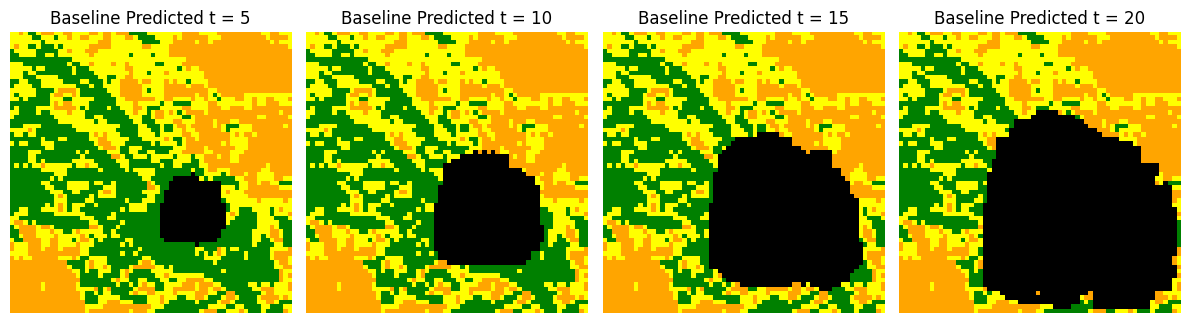

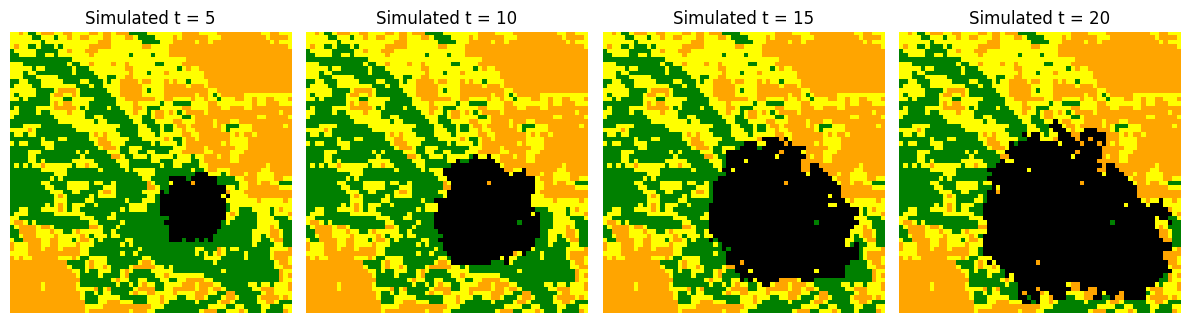

Diffusion - Overestimate: 0.562% | Underestimate: 0.415%, Total Mismatch: 0.977%
Diffusion - Overestimate: 1.831% | Underestimate: 0.342%, Total Mismatch: 2.173%
Diffusion - Overestimate: 2.515% | Underestimate: 1.465%, Total Mismatch: 3.979%
Diffusion - Overestimate: 4.834% | Underestimate: 2.417%, Total Mismatch: 7.251%
[-1  0  1]
[-1  0  1]
[-1  0  1]
[-1  0  1]


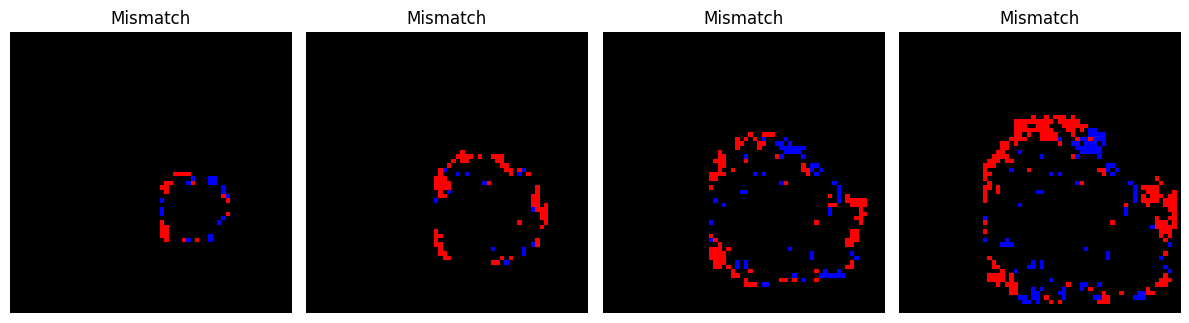

CNN - Overestimate: 0.635% | Underestimate: 0.366%, Total Mismatch: 1.001%
CNN - Overestimate: 2.173% | Underestimate: 0.049%, Total Mismatch: 2.222%
CNN - Overestimate: 4.81% | Underestimate: 0.024%, Total Mismatch: 4.834%
CNN - Overestimate: 10.107% | Underestimate: 0.073%, Total Mismatch: 10.181%
[-1  0  1]
[-1  0  1]
[-1  0  1]
[-1  0  1]


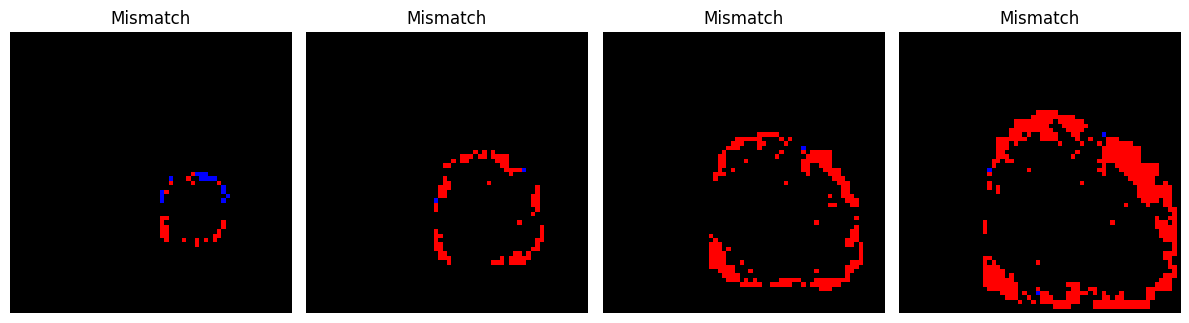

144 160


sampling loop time step: 100%|████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 41.14it/s]


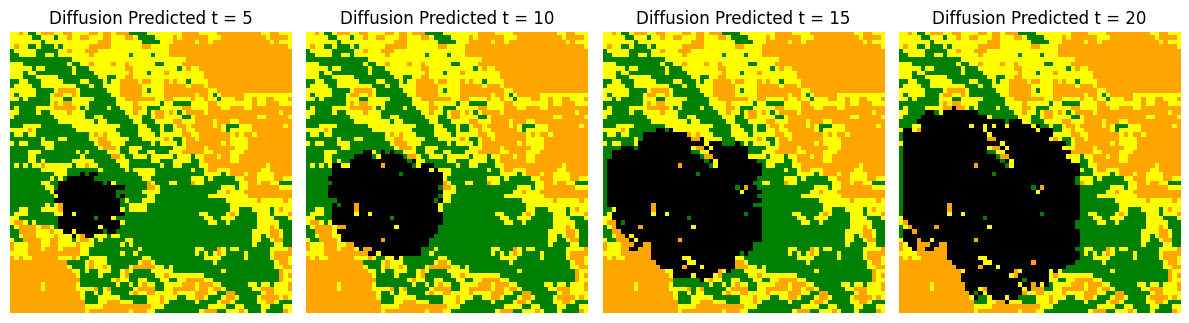

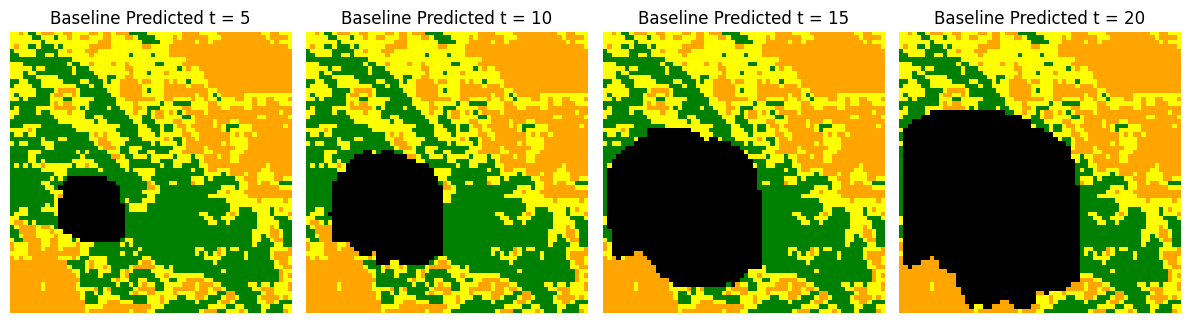

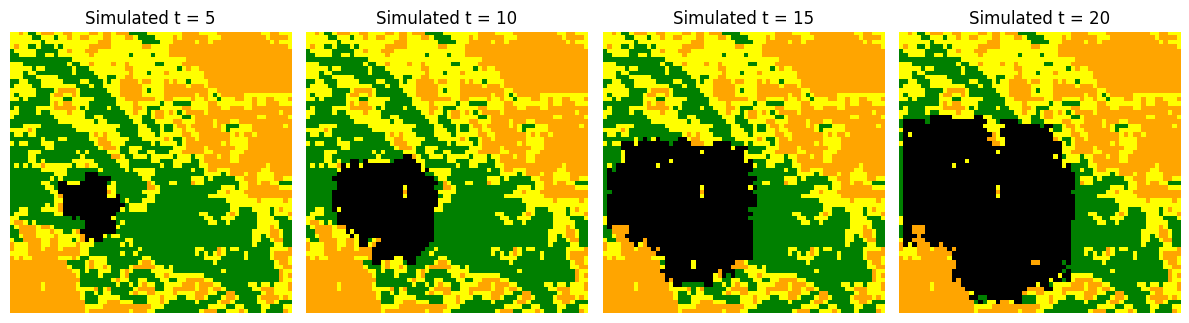

Diffusion - Overestimate: 1.123% | Underestimate: 0.415%, Total Mismatch: 1.538%
Diffusion - Overestimate: 2.002% | Underestimate: 0.806%, Total Mismatch: 2.808%
Diffusion - Overestimate: 2.417% | Underestimate: 1.953%, Total Mismatch: 4.37%
Diffusion - Overestimate: 2.515% | Underestimate: 2.417%, Total Mismatch: 4.932%
[-1  0  1]
[-1  0  1]
[-1  0  1]
[-1  0  1]


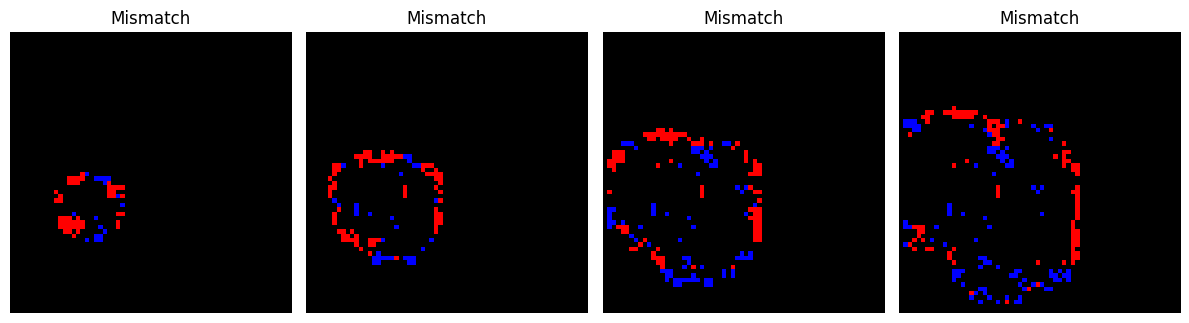

CNN - Overestimate: 1.636% | Underestimate: 0.146%, Total Mismatch: 1.782%
CNN - Overestimate: 2.954% | Underestimate: 0.171%, Total Mismatch: 3.125%
CNN - Overestimate: 4.614% | Underestimate: 0.171%, Total Mismatch: 4.785%
CNN - Overestimate: 5.64% | Underestimate: 0.244%, Total Mismatch: 5.884%
[-1  0  1]
[-1  0  1]
[-1  0  1]
[-1  0  1]


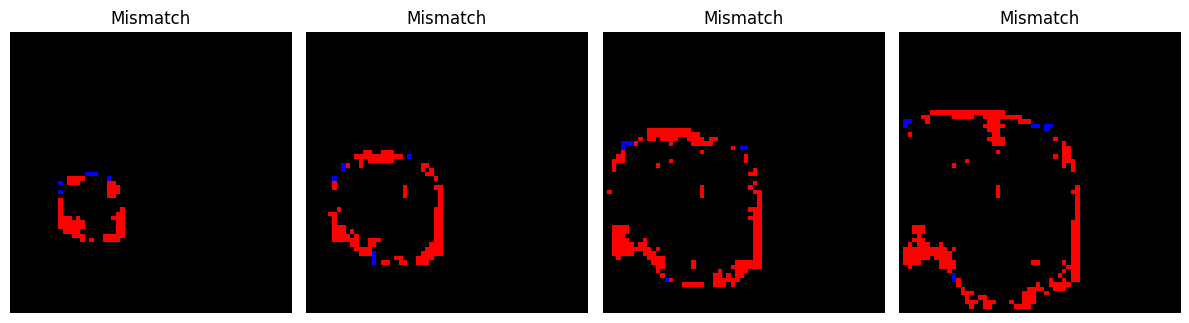

In [63]:
batch_size = 16
all_gts = []
all_preds_diffusion = []
all_preds_cnn = []
all_mismatches_diffusion = []
all_mismatches_cnn = []

for batch in range(10):
    start_index = batch * batch_size
    end_index = start_index + batch_size
    print(start_index, end_index)
    
    # Load the batch of data
    data = [simulated_data[i] for i in range(start_index, end_index)]
    input_img = data[0][1]  # Select the input image

    # Generate predictions using the diffusion model
    outputs_diffusion = generate_predictions(input_img, diffusion)
    all_preds_diffusion.append(outputs_diffusion)

    # Generate predictions using the CNN model
    outputs_cnn = generate_baseline_preds(input_img)
    all_preds_cnn.append(outputs_cnn)

    # Plot diffusion model predictions
    plot_images_in_row(outputs_diffusion, type_output="predicted (diffusion)")
    
    # Plot CNN model predictions
    plot_images_in_row(outputs_cnn, type_output="predicted (cnn)")

    # Prepare ground truth images
    ground_truth = []
    for i in range(0, len(data), 5):  # Adjust step as needed
        ground_truth.append(data[i][0].squeeze())
    all_gts.append(ground_truth)
    
    # Plot ground truth images
    plot_images_in_row(ground_truth, type_output="simulation")

    # Compute mismatches for diffusion model predictions
    mismatch_diffusion = []
    mismatch_percentages_diffusion = []
    for i in range(4):
        predicted = outputs_diffusion[i]
        simulated = ground_truth[i]
        mismatch_image, over_under_estimate, over_percent, under_percent, mismatch_percentage = compute_pixel_mismatch(predicted, simulated)
        mismatch_diffusion.append(over_under_estimate)
        mismatch_percentages_diffusion.append((over_percent, under_percent, mismatch_percentage))
        print(f"Diffusion - Overestimate: {over_percent}% | Underestimate: {under_percent}%, Total Mismatch: {mismatch_percentage}%")
    
    all_mismatches_diffusion.append(mismatch_diffusion)
    plot_images_in_row(mismatch_diffusion, type_output="mismatch (diffusion)", mismatch_stat=mismatch_percentages_diffusion)

    # Compute mismatches for CNN model predictions
    mismatch_cnn = []
    mismatch_percentages_cnn = []
    for i in range(4):
        predicted = outputs_cnn[i]
        simulated = ground_truth[i]
        mismatch_image, over_under_estimate, over_percent, under_percent, mismatch_percentage = compute_pixel_mismatch(predicted, simulated)
        mismatch_cnn.append(over_under_estimate)
        mismatch_percentages_cnn.append((over_percent, under_percent, mismatch_percentage))
        print(f"CNN - Overestimate: {over_percent}% | Underestimate: {under_percent}%, Total Mismatch: {mismatch_percentage}%")
    
    all_mismatches_cnn.append(mismatch_cnn)
    plot_images_in_row(mismatch_cnn, type_output="mismatch (cnn)", mismatch_stat=mismatch_percentages_cnn)

0 16


sampling loop time step: 100%|████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 42.51it/s]


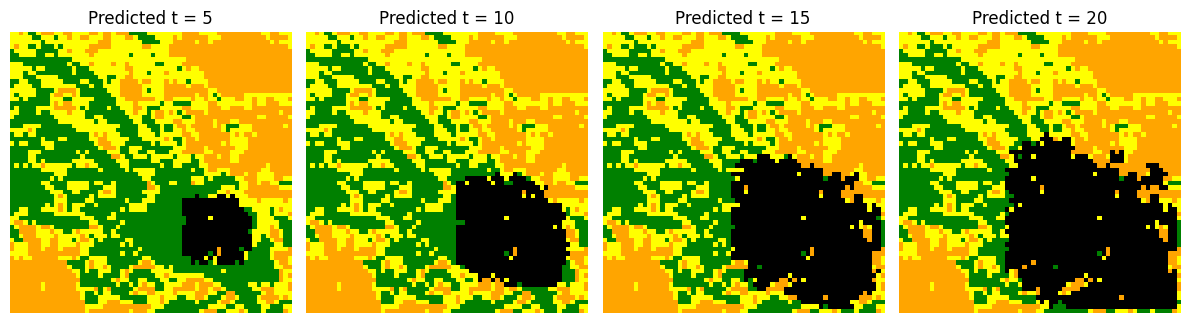

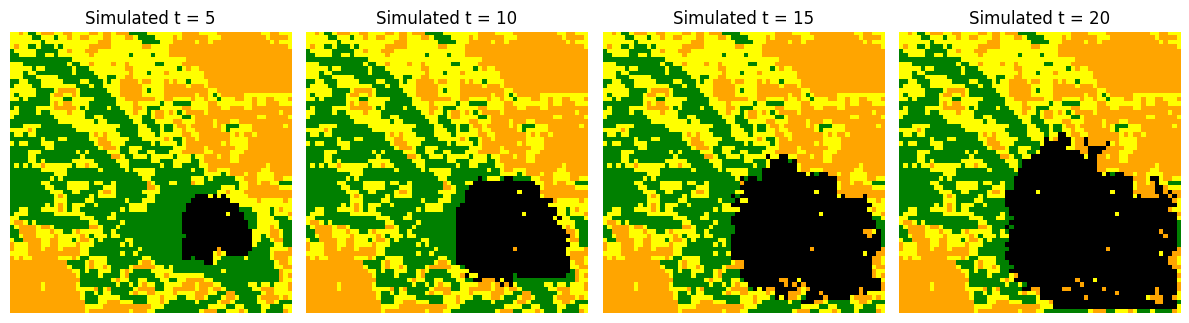

overestimate: 0.781% | underestimate: 0.342%, total mismatch: 1.123%
overestimate: 1.562% | underestimate: 0.708%, total mismatch: 2.271%
overestimate: 2.979% | underestimate: 1.416%, total mismatch: 4.395%
overestimate: 2.881% | underestimate: 2.271%, total mismatch: 5.151%


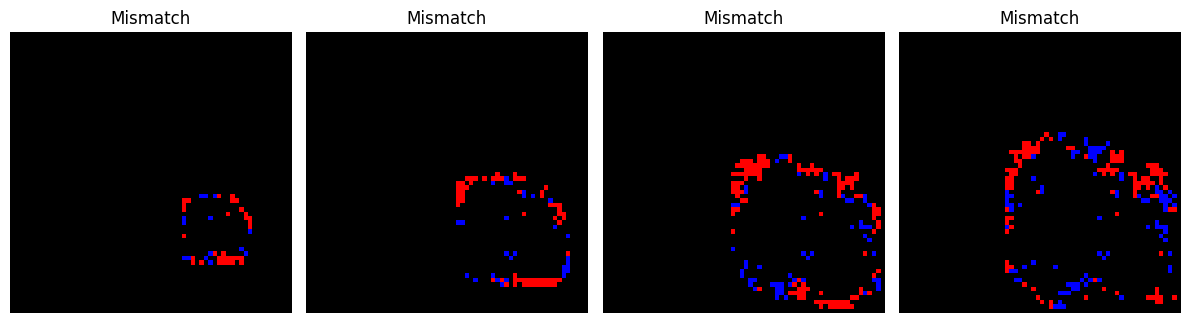

16 32


sampling loop time step: 100%|████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 41.61it/s]


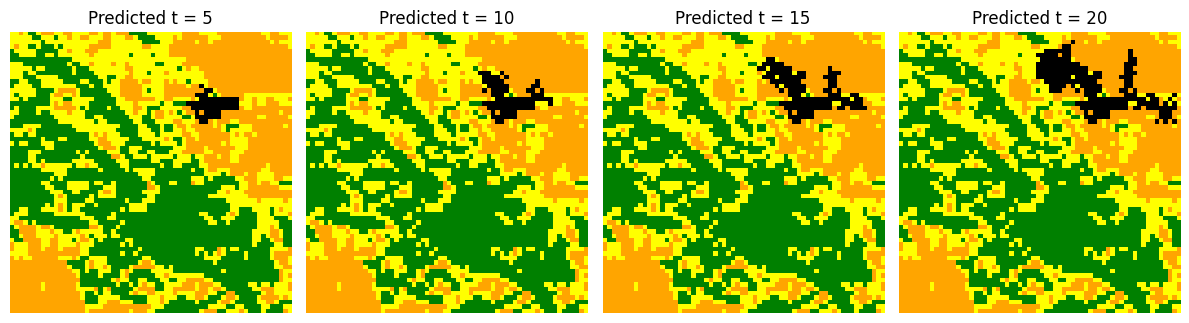

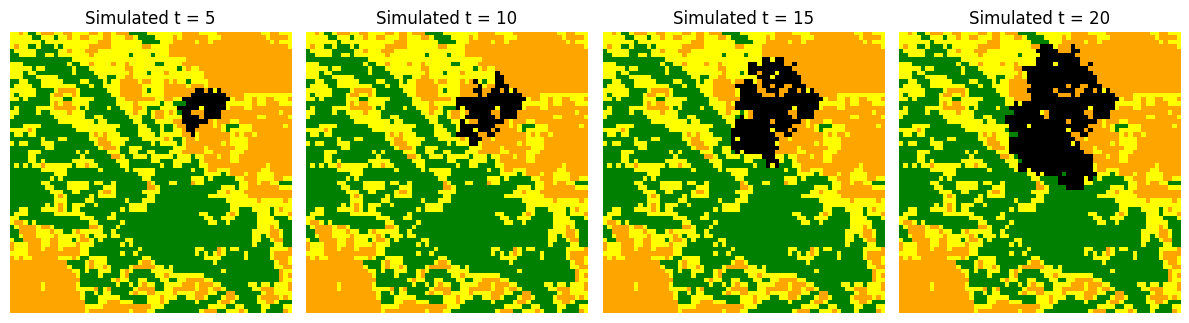

overestimate: 0.317% | underestimate: 0.732%, total mismatch: 1.05%
overestimate: 0.977% | underestimate: 1.88%, total mismatch: 2.856%
overestimate: 1.392% | underestimate: 4.712%, total mismatch: 6.104%
overestimate: 2.124% | underestimate: 8.545%, total mismatch: 10.669%


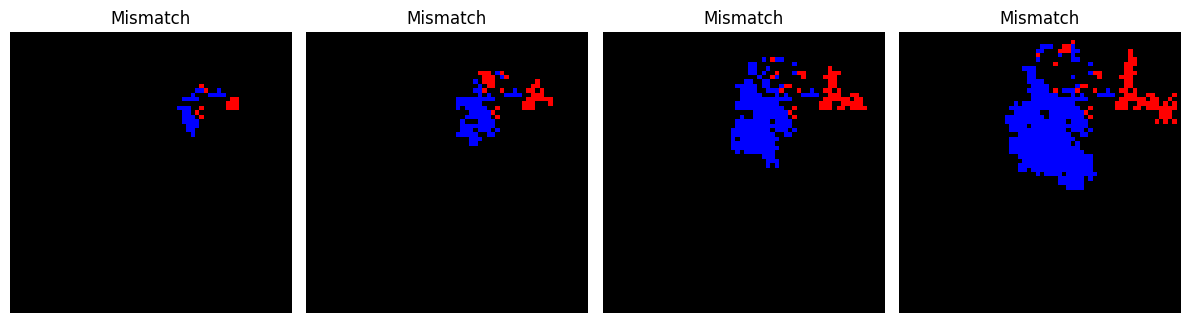

32 48


sampling loop time step: 100%|████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 41.62it/s]


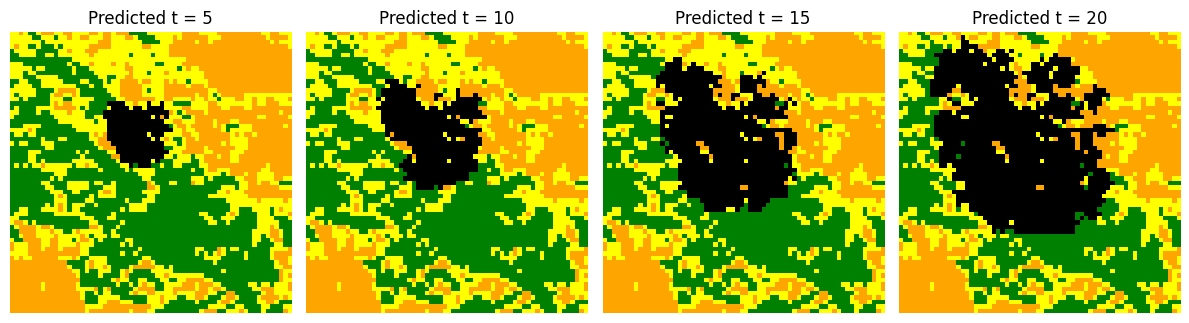

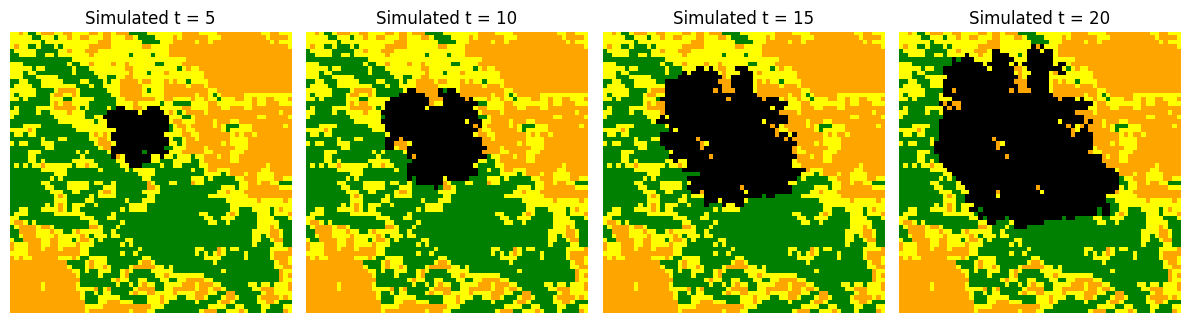

overestimate: 0.684% | underestimate: 0.293%, total mismatch: 0.977%
overestimate: 1.392% | underestimate: 1.196%, total mismatch: 2.588%
overestimate: 2.71% | underestimate: 2.271%, total mismatch: 4.98%
overestimate: 5.103% | underestimate: 3.662%, total mismatch: 8.765%


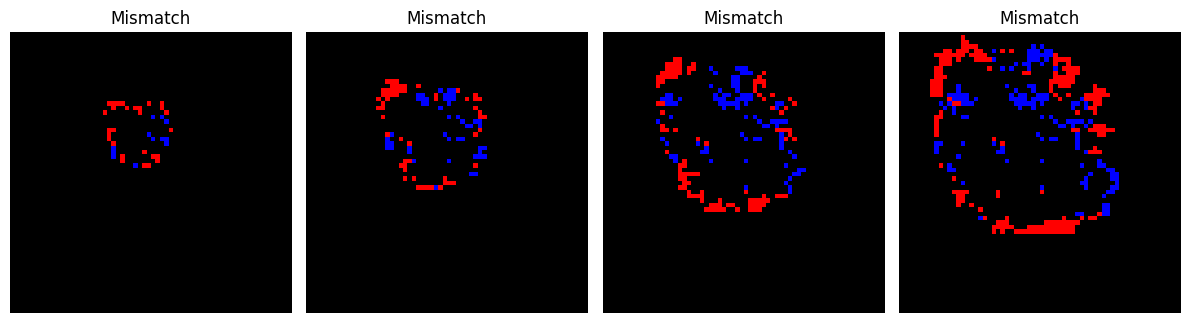

48 64


sampling loop time step: 100%|████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 42.06it/s]


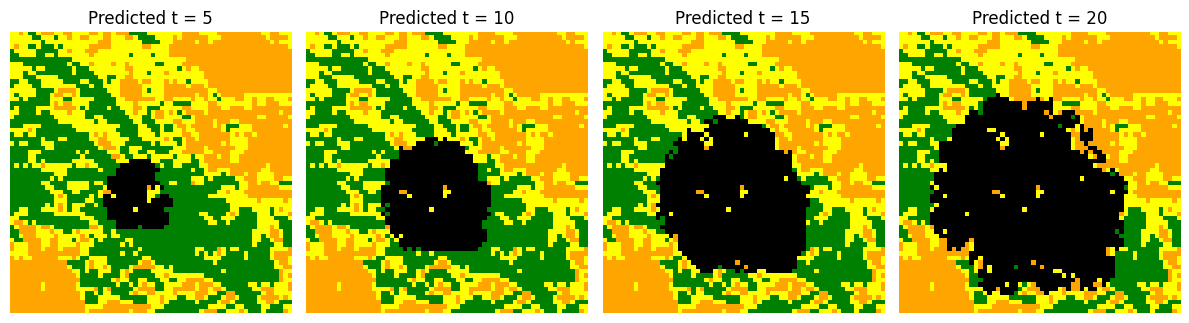

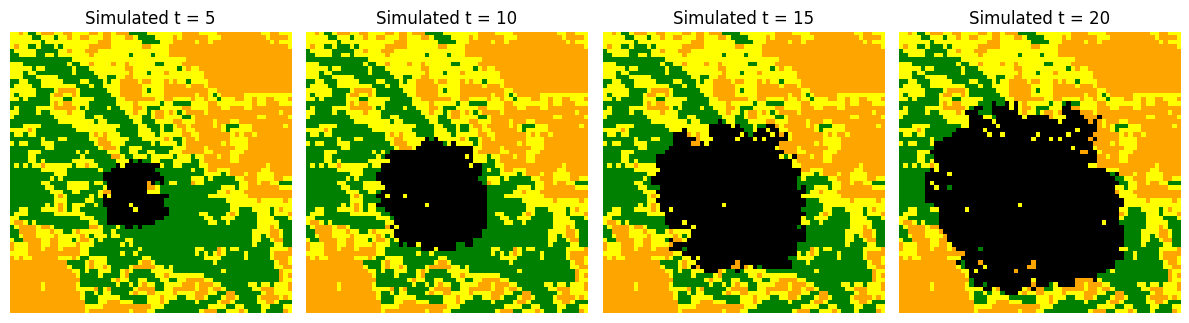

overestimate: 0.659% | underestimate: 0.488%, total mismatch: 1.147%
overestimate: 1.147% | underestimate: 0.879%, total mismatch: 2.026%
overestimate: 2.515% | underestimate: 1.392%, total mismatch: 3.906%
overestimate: 3.394% | underestimate: 3.198%, total mismatch: 6.592%


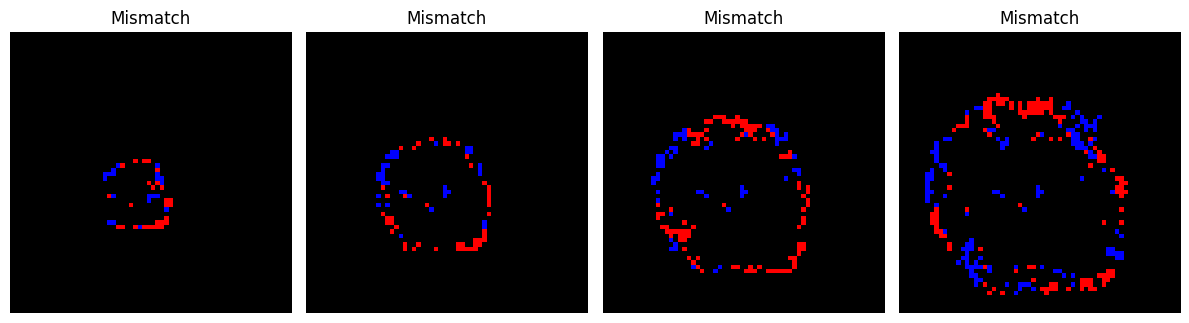

64 80


sampling loop time step: 100%|████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 41.97it/s]


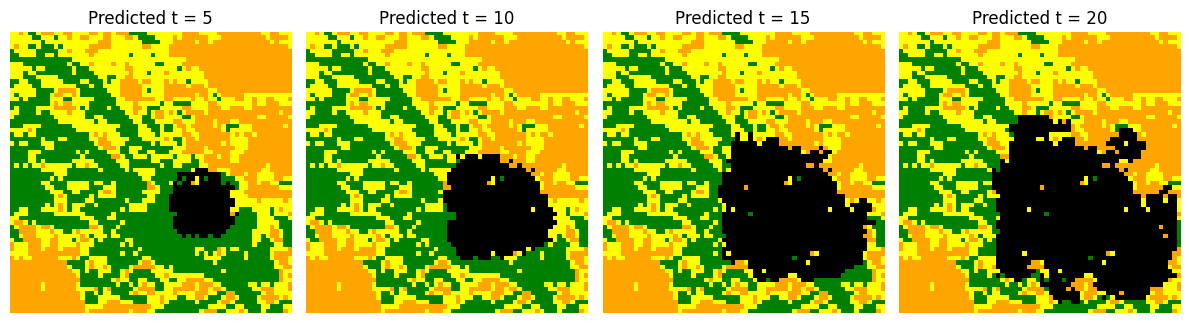

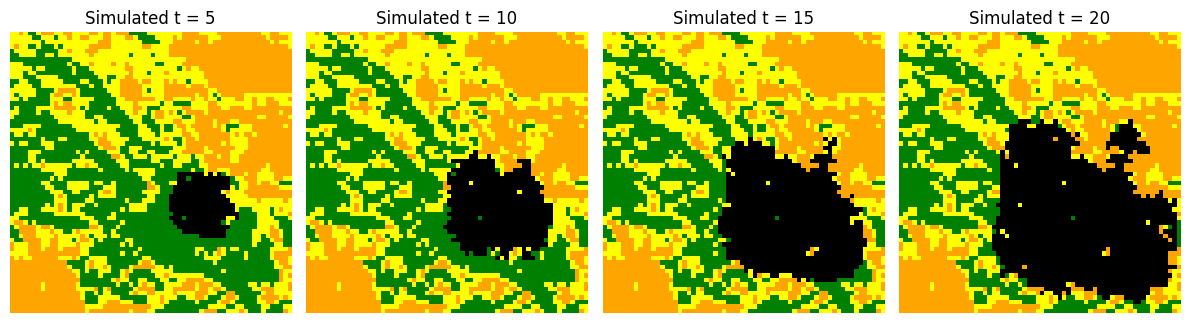

overestimate: 0.537% | underestimate: 0.391%, total mismatch: 0.928%
overestimate: 1.392% | underestimate: 0.684%, total mismatch: 2.075%
overestimate: 2.393% | underestimate: 1.465%, total mismatch: 3.857%
overestimate: 2.881% | underestimate: 2.734%, total mismatch: 5.615%


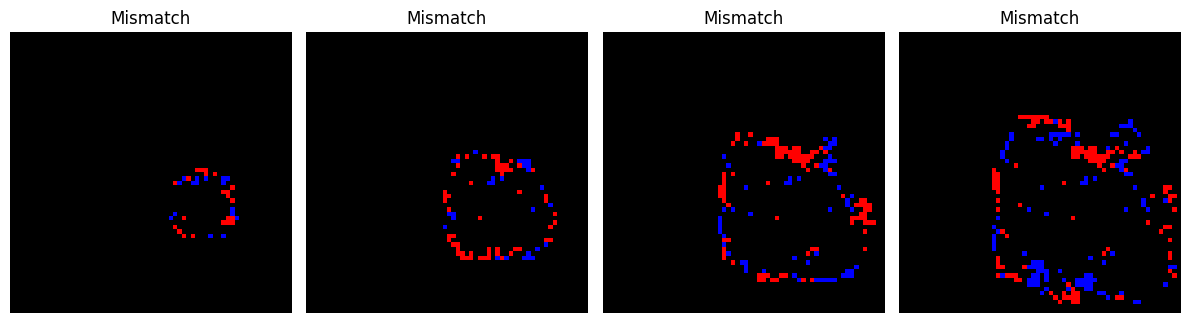

80 96


sampling loop time step: 100%|████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 41.97it/s]


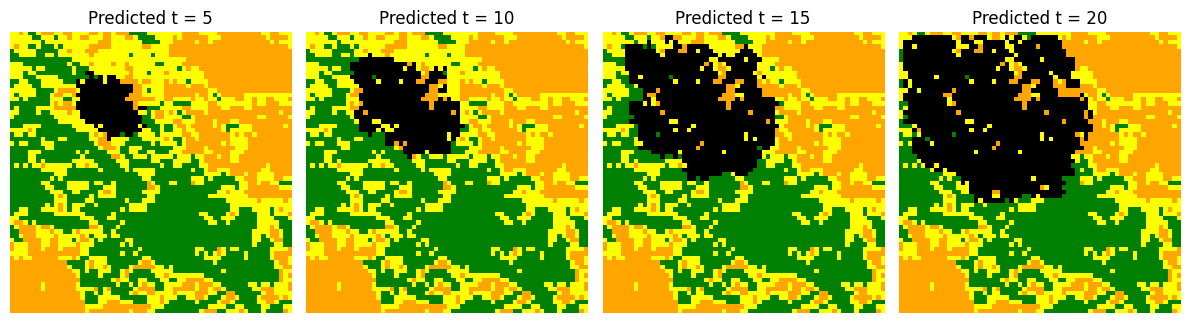

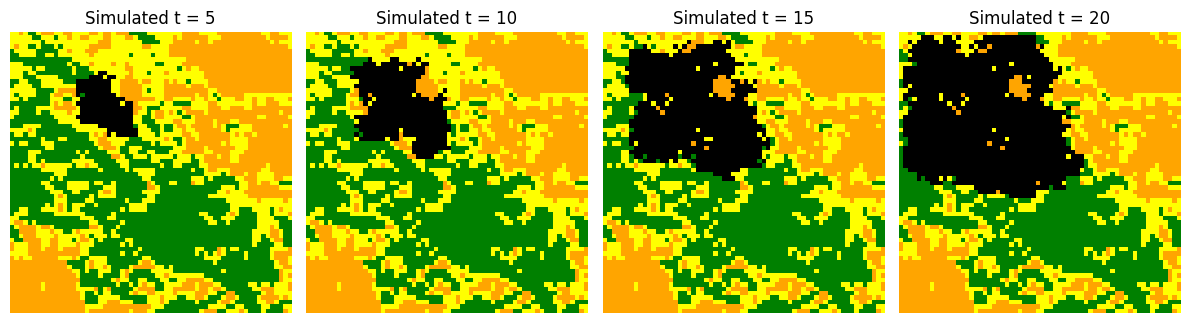

overestimate: 0.854% | underestimate: 0.269%, total mismatch: 1.123%
overestimate: 2.148% | underestimate: 1.099%, total mismatch: 3.247%
overestimate: 3.809% | underestimate: 2.637%, total mismatch: 6.445%
overestimate: 5.176% | underestimate: 3.784%, total mismatch: 8.96%


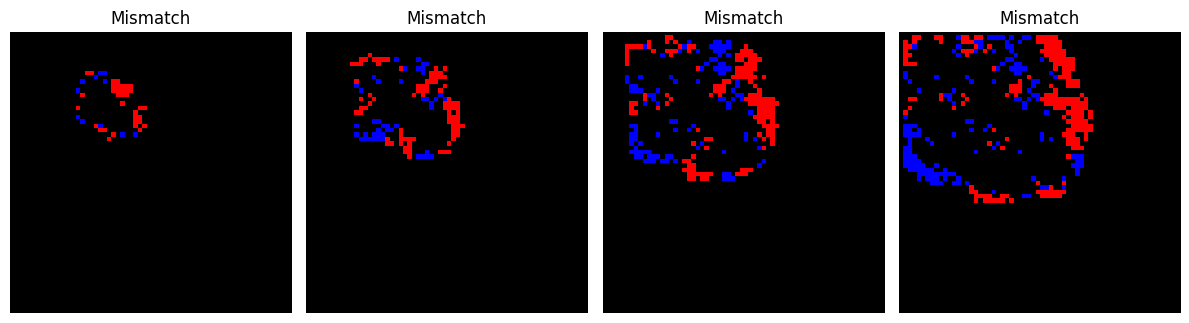

96 112


sampling loop time step: 100%|████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 41.82it/s]


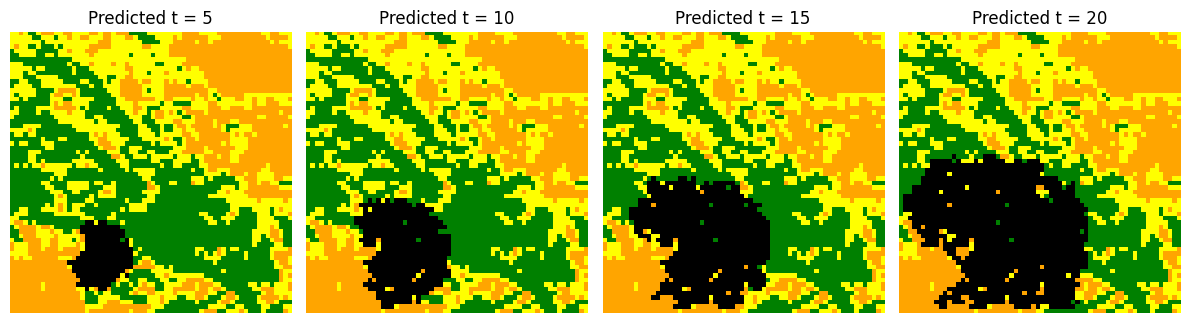

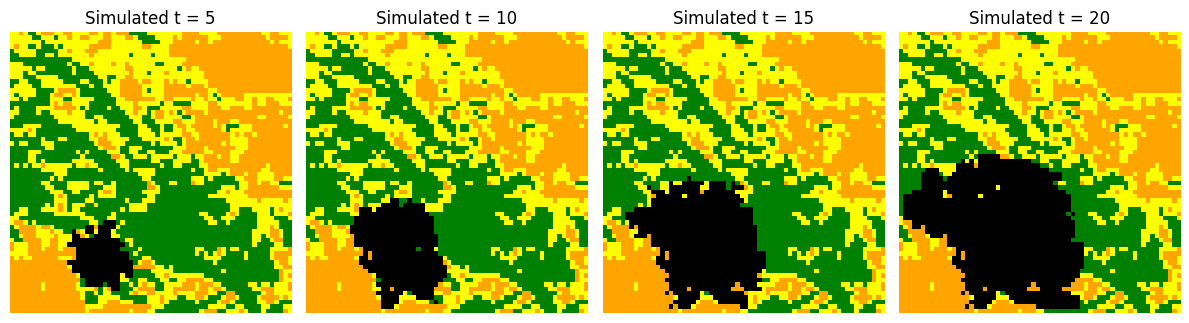

overestimate: 0.757% | underestimate: 0.562%, total mismatch: 1.318%
overestimate: 1.514% | underestimate: 0.952%, total mismatch: 2.466%
overestimate: 2.515% | underestimate: 1.318%, total mismatch: 3.833%
overestimate: 3.467% | underestimate: 1.66%, total mismatch: 5.127%


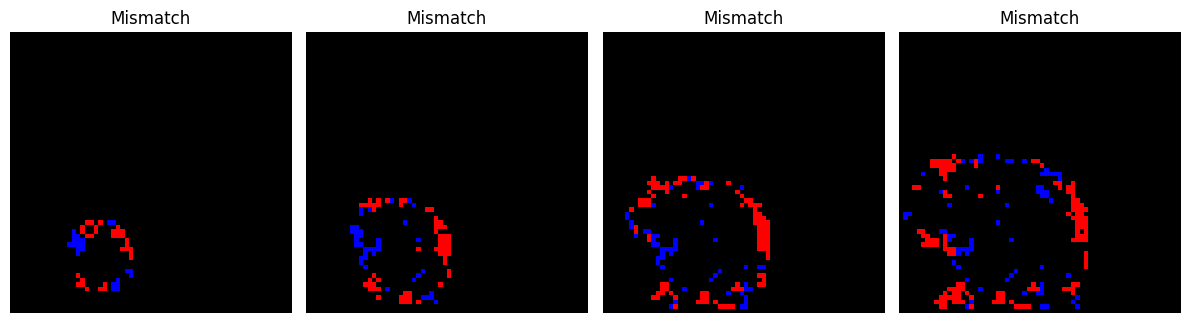

112 128


sampling loop time step: 100%|████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 42.30it/s]


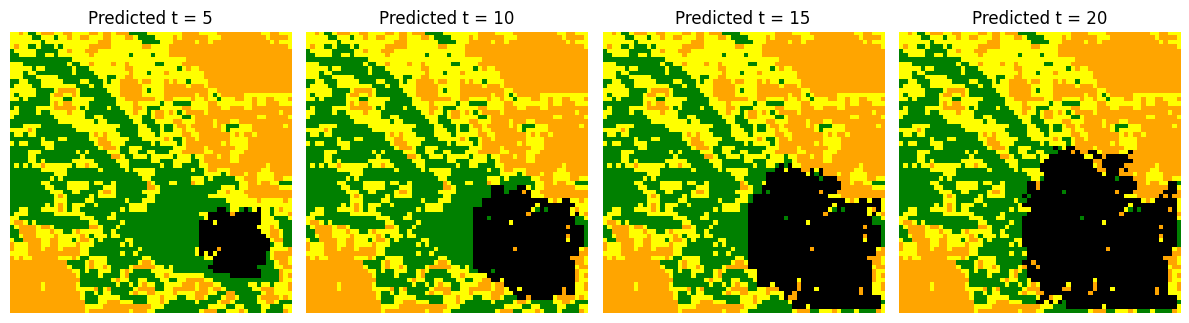

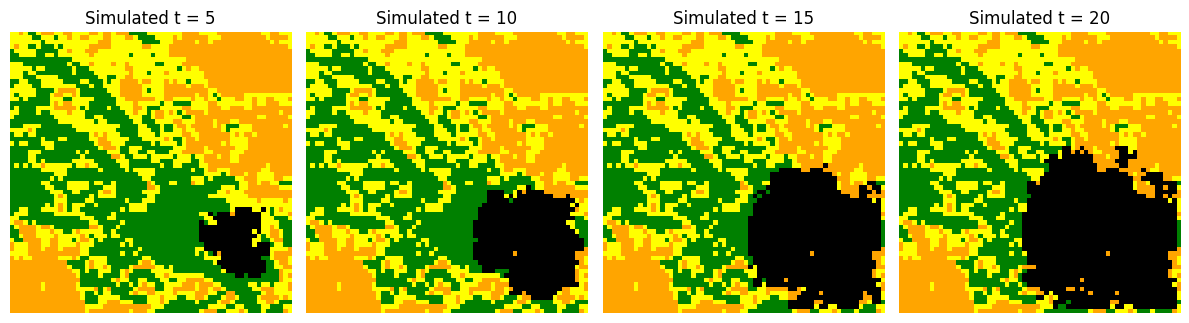

overestimate: 0.781% | underestimate: 0.269%, total mismatch: 1.05%
overestimate: 1.245% | underestimate: 0.879%, total mismatch: 2.124%
overestimate: 1.147% | underestimate: 1.782%, total mismatch: 2.93%
overestimate: 1.221% | underestimate: 2.417%, total mismatch: 3.638%


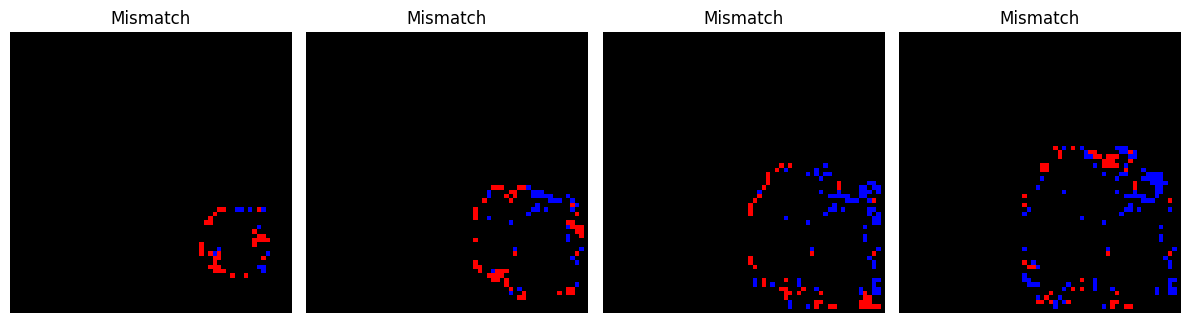

128 144


sampling loop time step: 100%|████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 42.23it/s]


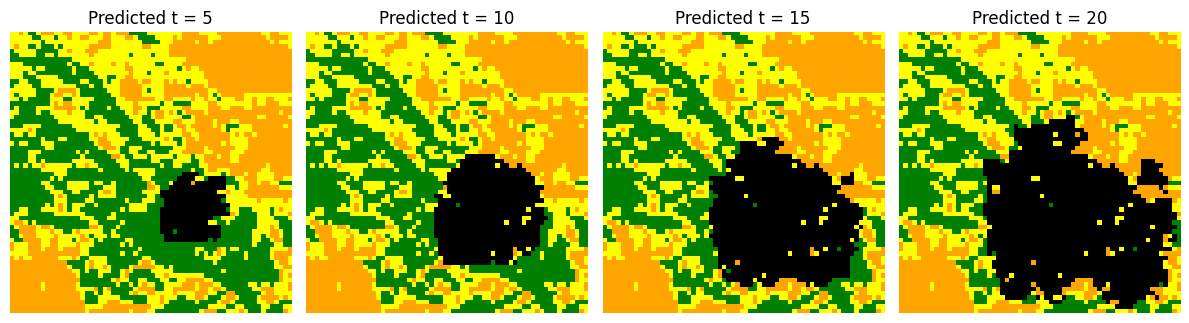

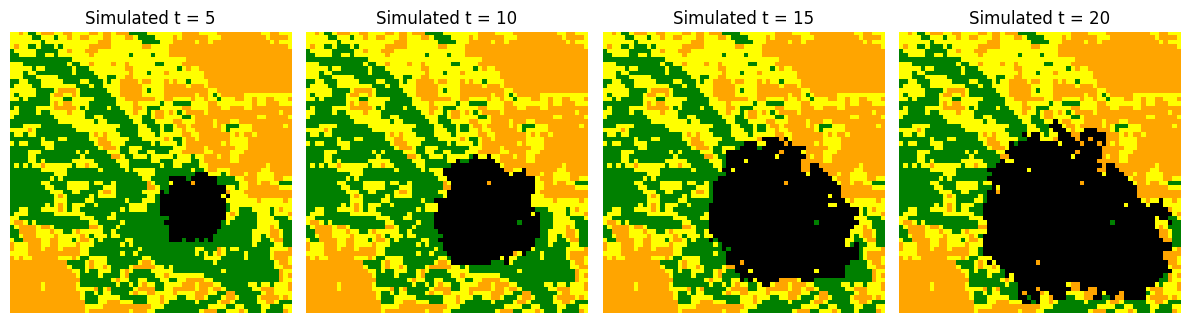

overestimate: 0.684% | underestimate: 0.513%, total mismatch: 1.196%
overestimate: 1.514% | underestimate: 0.439%, total mismatch: 1.953%
overestimate: 2.051% | underestimate: 1.294%, total mismatch: 3.345%
overestimate: 4.468% | underestimate: 2.563%, total mismatch: 7.031%


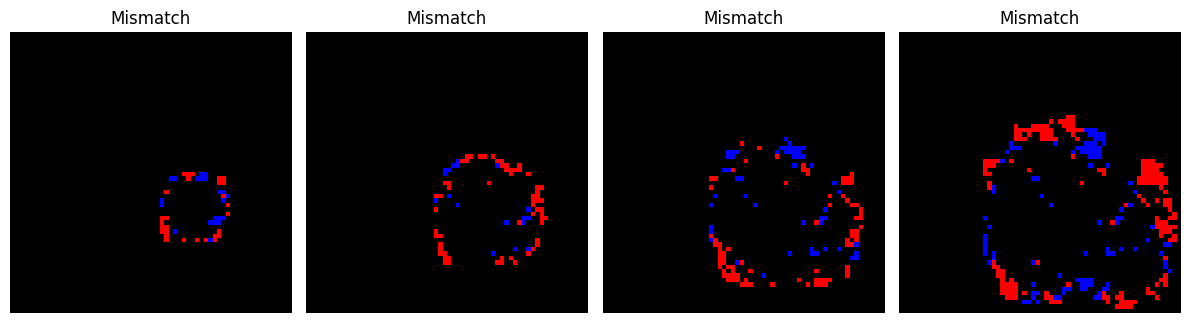

144 160


sampling loop time step: 100%|████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 41.03it/s]


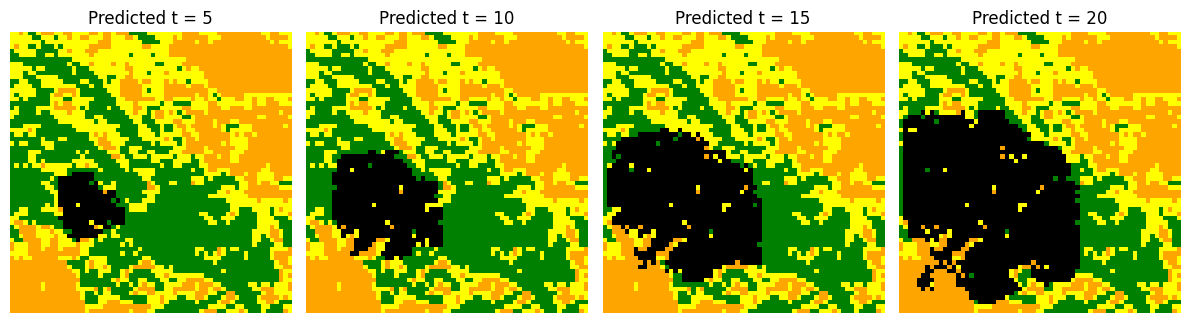

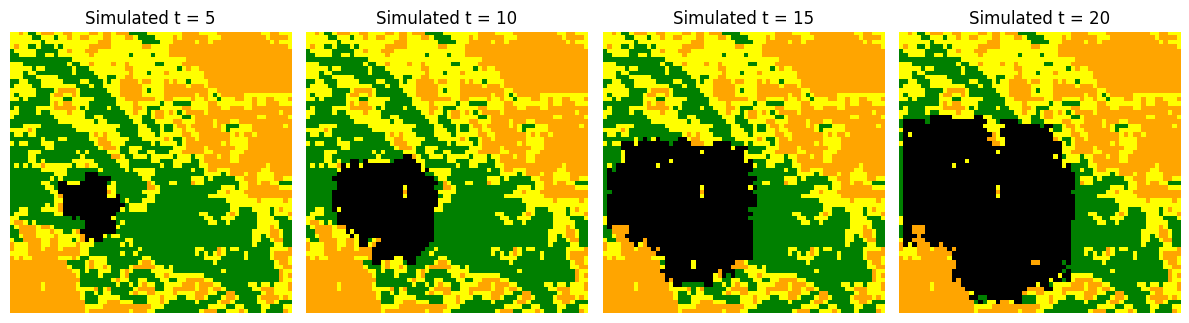

overestimate: 1.172% | underestimate: 0.684%, total mismatch: 1.855%
overestimate: 1.782% | underestimate: 1.465%, total mismatch: 3.247%
overestimate: 2.588% | underestimate: 2.661%, total mismatch: 5.249%
overestimate: 3.345% | underestimate: 3.32%, total mismatch: 6.665%


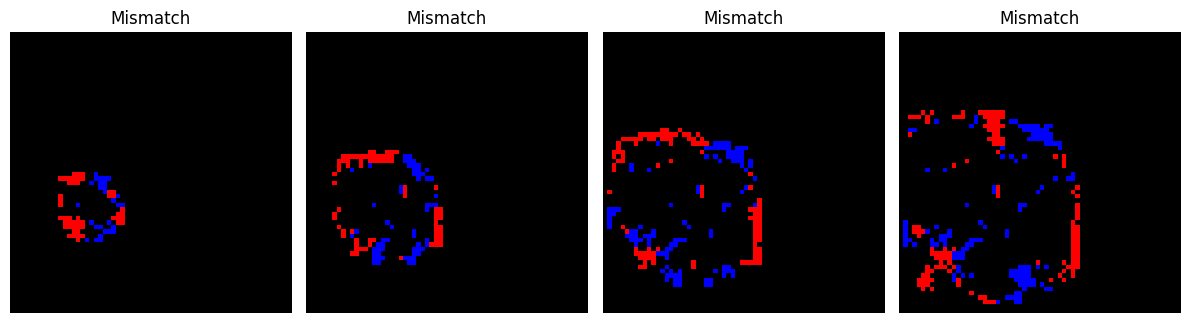

In [8]:
batch_size = 16
all_gts = []
all_preds = []
all_mismatches = []

for batch in range(10):
    start_index = batch * batch_size
    end_index = start_index + batch_size
    print(start_index, end_index)
    
    data = [simulated_data[i] for i in range(start_index, end_index)]
    
    input_img = data[0][1]
    
    outputs = generate_predictions(input_img, diffusion)
    all_preds.append(outputs)

    plot_images_in_row(outputs, type_output="predicted")

    ground_truth = []
    for i in range(0, len(data), 5):
        ground_truth.append(data[i][0].squeeze())

    all_gts.append(ground_truth)
        
    plot_images_in_row(ground_truth)
    
    mismatch = []
    mismatch_percentages = []
    for i in range(4):
        predicted = outputs[i]
        simulated = ground_truth[i]
        mismatch_image, over_under_estimate, over_percent, under_percent, mismatch_percentage  = compute_pixel_mismatch(predicted, simulated)
        mismatch.append(over_under_estimate)
        mismatch_percentages.append((over_percent, under_percent, mismatch_percentage))
        print(f"overestimate: {over_percent}% | underestimate: {under_percent}%, total mismatch: {mismatch_percentage}%")
        
    all_mismatches.append(mismatch)
    plot_images_in_row(mismatch, type_output="mismatch", mismatch_stat=mismatch_percentages)
    


In [40]:
def compute_fpr_fnr(prediction_sequences, ground_truth_sequences):
    """
    Compute the FPR and FNR averaged across 10 sequences, where each sequence contains 4 time interval images (64x64).
    Args:
        prediction_sequences (numpy.ndarray): A numpy array of shape (10, 4, 64, 64) representing 10 sequences,
                                              each with 4 time interval images.
        ground_truth_sequences (numpy.ndarray): A numpy array of shape (10, 4, 64, 64) representing the corresponding
                                                ground truth sequences.
    Returns:
        fpr (numpy.ndarray): Averaged FPR values of shape (4,) for each time interval.
        fnr (numpy.ndarray): Averaged FNR values of shape (4,) for each time interval.
    """
    num_sequences = prediction_sequences.shape[0]
    print(num_sequences)
    time_intervals = prediction_sequences.shape[1]
    print(time_intervals)
    print(prediction_sequences.shape)
    
    fpr_list = []
    fnr_list = []
    
    for t in range(time_intervals):
        fp = 0
        fn = 0
        tn = 0
        tp = 0
        
        for i in range(num_sequences):
            pred = prediction_sequences[i, t]
            gt = ground_truth_sequences[i, t]
            
            fp += np.sum((pred == 1) & (gt == 0))
            fn += np.sum((pred == 0) & (gt == 1))
            tn += np.sum((pred == 0) & (gt == 0))
            tp += np.sum((pred == 1) & (gt == 1))
        print(fp, fn, tp, tn)
        # Calculate FPR and FNR for this time interval
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        
        fpr_list.append(fpr)
        fnr_list.append(fnr)
    
    return np.array(fpr_list), np.array(fnr_list)

def compute_metrics(prediction_sequences, ground_truth_sequences):
    """
    Compute the averaged precision, recall, F1 score, FPR, and FNR across 10 sequences, where each sequence contains
    4 time interval images (64x64).
    Args:
        prediction_sequences (numpy.ndarray): A numpy array of shape (10, 4, 64, 64) representing 10 sequences,
                                              each with 4 time interval images.
        ground_truth_sequences (numpy.ndarray): A numpy array of shape (10, 4, 64, 64) representing the corresponding
                                                ground truth sequences.
    Returns:
        metrics_dict (dict): A dictionary containing the averaged metrics (precision, recall, F1 score, FPR, and FNR)
                             for each time interval.
    """
    num_sequences = prediction_sequences.shape[0]
    time_intervals = prediction_sequences.shape[1]
    
    # Initialize lists to store the metrics for each time interval
    precision_list = []
    recall_list = []
    f1_list = []
    fpr_list = []
    fnr_list = []
    
    for t in range(time_intervals):
        fp = 0
        fn = 0
        tn = 0
        tp = 0
        
        for i in range(num_sequences):
            pred = prediction_sequences[i, t]
            gt = ground_truth_sequences[i, t]
            
            fp += np.sum((pred == 1) & (gt == 0))
            fn += np.sum((pred == 0) & (gt == 1))
            tn += np.sum((pred == 0) & (gt == 0))
            tp += np.sum((pred == 1) & (gt == 1))
        
        # Calculate precision, recall, F1 score, FPR, and FNR for this time interval
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        
        # Append the metrics to their respective lists
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        fpr_list.append(fpr)
        fnr_list.append(fnr)
    
    # Convert the lists to numpy arrays for easier manipulation
    metrics_dict = {
        "precision": np.array(precision_list),
        "recall": np.array(recall_list),
        "f1_score": np.array(f1_list),
        "fpr": np.array(fpr_list),
        "fnr": np.array(fnr_list)
    }
    
    return metrics_dict

def print_metrics(metrics_dict, time_intervals):
    print(f"{'Time Interval (hours)':<20}{'Precision':<12}{'Recall':<12}{'F1 Score':<12}{'FPR':<12}{'FNR':<12}")
    for i, interval in enumerate(time_intervals):
        print(f"{interval:<20}{metrics_dict['precision'][i]:<12.4f}{metrics_dict['recall'][i]:<12.4f}"
              f"{metrics_dict['f1_score'][i]:<12.4f}{metrics_dict['fpr'][i]:<12.4f}{metrics_dict['fnr'][i]:<12.4f}")

def plot_fpr_fnr(fpr, fnr, time_intervals):
    plt.figure(figsize=(10, 6))
    plt.plot(time_intervals, fpr, marker='o', label='FPR')
    plt.plot(time_intervals, fnr, marker='o', label='FNR')
    plt.xlabel('Time Intervals (hours)')
    plt.ylabel('Rate')
    plt.title('Average FPR and FNR at Different Time Intervals')
    plt.xticks(time_intervals)
    plt.legend()
    plt.grid(True)
    plt.show()

time_intervals = [30, 60, 90, 120]

metrics_dict = compute_metrics(np.array(all_preds_diffusion), np.array(all_gts))
print_metrics(metrics_dict, time_intervals)

metrics_dict_cnn = compute_metrics(np.array(all_preds_cnn), np.array(all_gts))
print_metrics(metrics_dict_cnn, time_intervals)

Time Interval (hours)Precision   Recall      F1 Score    FPR         FNR         
30                  0.8193      0.9100      0.8623      0.0079      0.0900      
60                  0.8501      0.9081      0.8781      0.0172      0.0919      
90                  0.8586      0.8903      0.8742      0.0314      0.1097      
120                 0.8587      0.8902      0.8742      0.0545      0.1098      
Time Interval (hours)Precision   Recall      F1 Score    FPR         FNR         
30                  0.7581      0.9430      0.8405      0.0118      0.0570      
60                  0.7531      0.9763      0.8503      0.0344      0.0237      
90                  0.7424      0.9853      0.8468      0.0733      0.0147      
120                 0.7462      0.9880      0.8502      0.1250      0.0120      


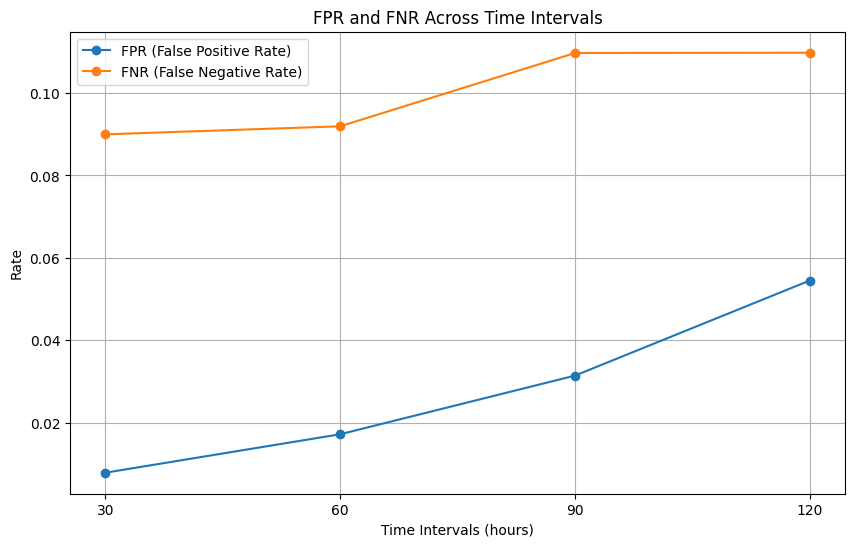

In [41]:
def plot_fpr_fnr(metrics_dict, time_intervals):
    plt.figure(figsize=(10, 6))
    plt.plot(time_intervals, metrics_dict['fpr'], marker='o', label='FPR (False Positive Rate)')
    plt.plot(time_intervals, metrics_dict['fnr'], marker='o', label='FNR (False Negative Rate)')
    plt.xlabel('Time Intervals (hours)')
    plt.ylabel('Rate')
    plt.title('FPR and FNR Across Time Intervals')
    plt.xticks(time_intervals)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_fpr_fnr(metrics_dict, time_intervals)

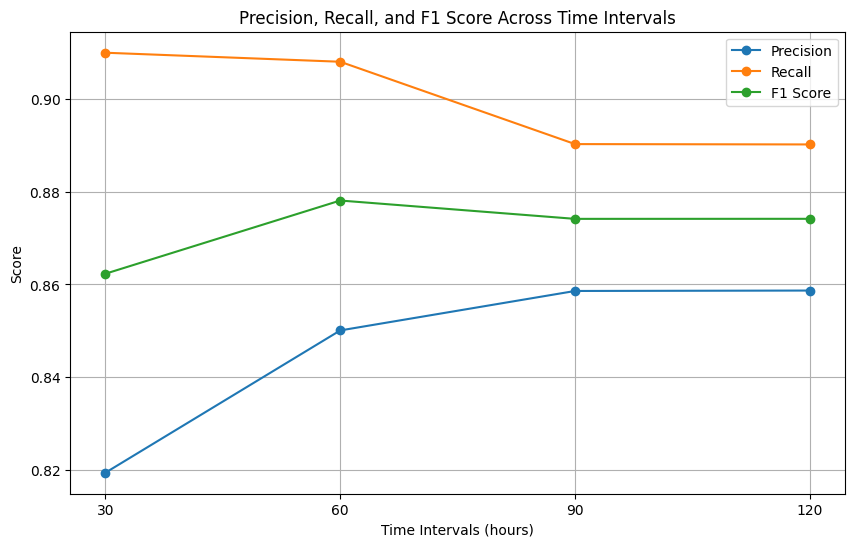

In [42]:
def plot_precision_recall_f1(metrics_dict, time_intervals):
    plt.figure(figsize=(10, 6))
    plt.plot(time_intervals, metrics_dict['precision'], marker='o', label='Precision')
    plt.plot(time_intervals, metrics_dict['recall'], marker='o', label='Recall')
    plt.plot(time_intervals, metrics_dict['f1_score'], marker='o', label='F1 Score')
    plt.xlabel('Time Intervals (hours)')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1 Score Across Time Intervals')
    plt.xticks(time_intervals)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_precision_recall_f1(metrics_dict, time_intervals)

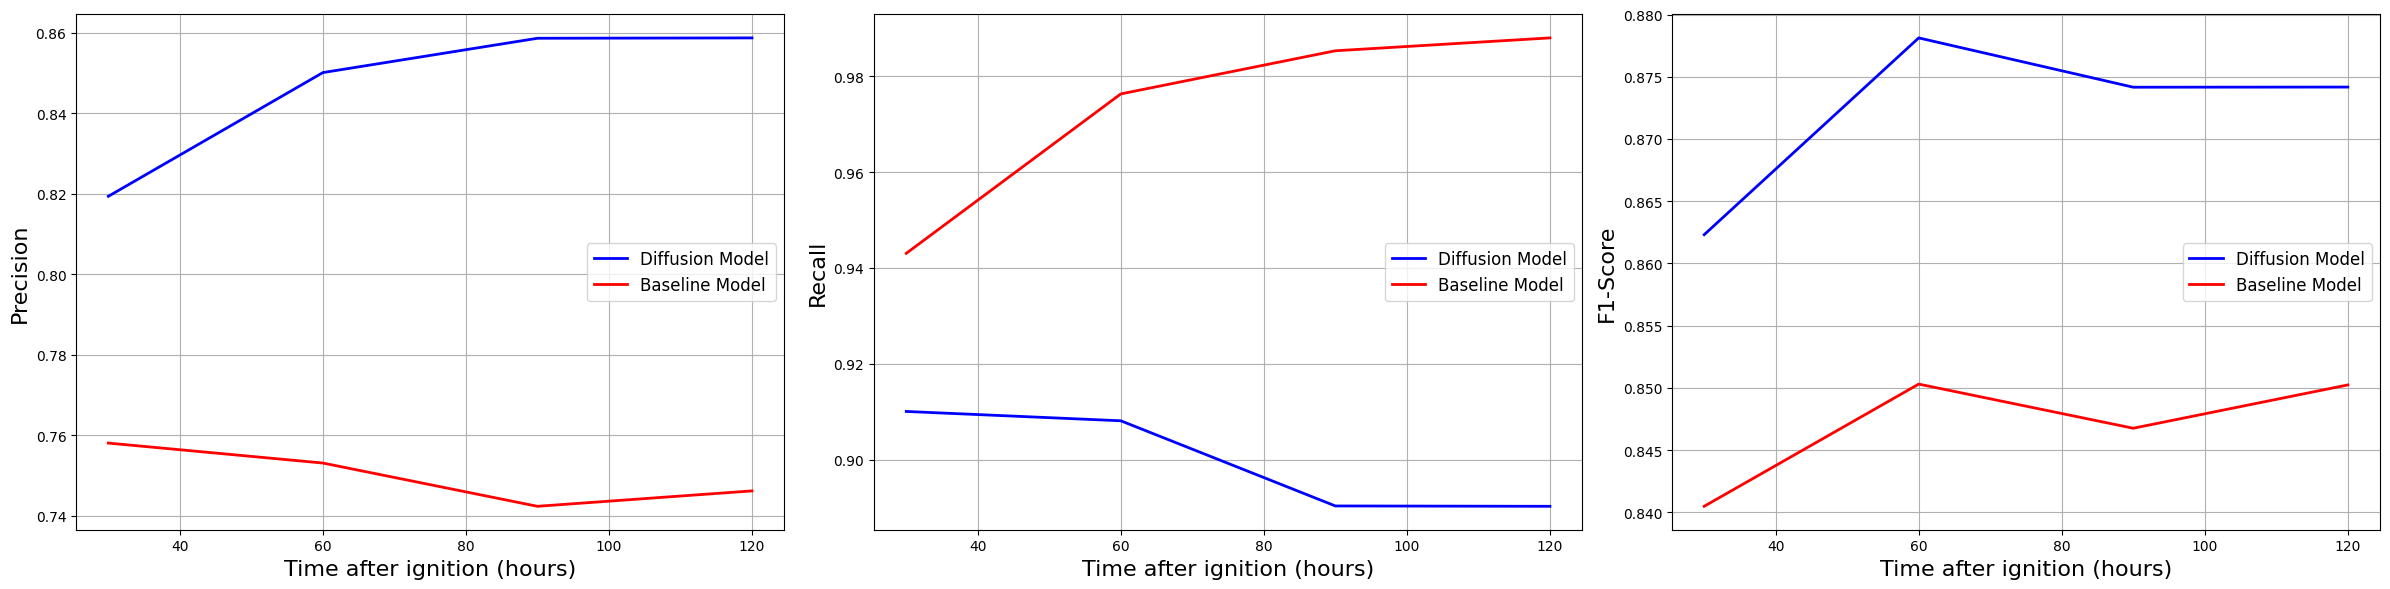

In [60]:
def plot_precision_recall_f1_subplots(metrics_dict_diff, metrics_dict_cnn, time_intervals):
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))

    # Plot each metric in a separate subplot
    axes[0].plot(time_intervals, metrics_dict_diff['precision'], color='blue',  linewidth=2, label="Diffusion Model")
    axes[0].plot(time_intervals, metrics_dict_cnn['precision'], color='red',  linewidth=2, label="Baseline Model")
    # axes[0].set_title('Precision Across Time Intervals')
    axes[0].set_xlabel('Time after ignition (hours)', fontsize=16)
    axes[0].set_ylabel('Precision', fontsize=16)
    axes[0].grid(True)
    axes[0].legend(fontsize=12, loc="center right")

    axes[1].plot(time_intervals, metrics_dict_diff['recall'], color='blue', linewidth=2, label="Diffusion Model")
    axes[1].plot(time_intervals, metrics_dict_cnn['recall'], color='red', linewidth=2, label="Baseline Model")
    # axes[1].set_title('Recall Across Time Intervals')
    axes[1].set_xlabel('Time after ignition (hours)', fontsize=16)
    axes[1].set_ylabel('Recall', fontsize=16)
    axes[1].grid(True)
    axes[1].legend(fontsize=12, loc="center right")
    
    axes[2].plot(time_intervals, metrics_dict_diff['f1_score'], color='blue',  linewidth=2, label="Diffusion Model")
    axes[2].plot(time_intervals, metrics_dict_cnn['f1_score'], color='red',  linewidth=2, label="Baseline Model")
    # axes[2].set_title('F1 Score Across Time Intervals')
    axes[2].set_xlabel('Time after ignition (hours)', fontsize=16)
    axes[2].set_ylabel('F1-Score', fontsize=16)
    axes[2].grid(True)
    axes[2].legend(fontsize=12, loc="center right") 

    #plt.suptitle('Precision, Recall, and F1 Score Across Time Intervals', fontsize=16)
    plt.tight_layout()
    plt.show()
plot_precision_recall_f1_subplots(metrics_dict, metrics_dict_cnn, time_intervals)

In [61]:
def plot_precision_recall_f1_subplots(metrics_dict_diff, metrics_dict_cnn, time_intervals):
    # Precision Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(time_intervals, metrics_dict_diff['precision'], color='blue',  linewidth=2, label="Diffusion Model")
    ax.plot(time_intervals, metrics_dict_cnn['precision'], color='red',  linewidth=2, label="Baseline Model")
    ax.set_xlabel('Time after ignition (hours)', fontsize=16)
    ax.set_ylabel('Precision', fontsize=16)
    ax.grid(True)
    ax.legend(fontsize=12, loc="center right")
    plt.tight_layout()
    fig.savefig('precision_plot.png', dpi=600, bbox_inches='tight')
    plt.close(fig)  # Close the figure to avoid overlapping with the next one

    # Recall Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(time_intervals, metrics_dict_diff['recall'], color='blue', linewidth=2, label="Diffusion Model")
    ax.plot(time_intervals, metrics_dict_cnn['recall'], color='red', linewidth=2, label="Baseline Model")
    ax.set_xlabel('Time after ignition (hours)', fontsize=16)
    ax.set_ylabel('Recall', fontsize=16)
    ax.grid(True)
    ax.legend(fontsize=12, loc="center right")
    plt.tight_layout()
    fig.savefig('recall_plot.png', dpi=600, bbox_inches='tight')
    plt.close(fig)

    # F1 Score Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(time_intervals, metrics_dict_diff['f1_score'], color='blue',  linewidth=2, label="Diffusion Model")
    ax.plot(time_intervals, metrics_dict_cnn['f1_score'], color='red',  linewidth=2, label="Baseline Model")
    ax.set_xlabel('Time after ignition (hours)', fontsize=16)
    ax.set_ylabel('F1-Score', fontsize=16)
    ax.grid(True)
    ax.legend(fontsize=12, loc="center right")
    plt.tight_layout()
    fig.savefig('f1_score_plot.png', dpi=600, bbox_inches='tight')
    plt.close(fig)

plot_precision_recall_f1_subplots(metrics_dict, metrics_dict_cnn, time_intervals)

In [44]:
def plot_and_save_precision_recall_f1_subplots(metrics_dict, time_intervals):
    # Define metric names and file names
    metric_names = ['Precision', 'Recall', 'F1_Score']
    colors = ['blue', 'green', 'red']
    file_names = ['precision_plot.jpg', 'recall_plot.jpg', 'f1_score_plot.jpg']

    # Plot each metric in a separate subplot and save as a .jpg image
    for i, metric_name in enumerate(metric_names):
        plt.figure(figsize=(6, 4))
        plt.plot(time_intervals, metrics_dict[metric_name.lower()], color=colors[i])
        # plt.title(f'{metric_name} Across Time Intervals')
        plt.xlabel('Time after ignition (hours)', fontsize=16)
        plt.ylabel(f"{metric_name}", fontsize=16)
        plt.grid(True)
        plt.xticks(time_intervals)
        plt.tight_layout()
        
        # Save each plot as a .jpg file
        plt.savefig(file_names[i], format='jpg')
        plt.close()  # Close the plot to prevent display if running in an interactive environment

    print(f'Plots saved as {file_names}')

# Example usage with your existing metrics_dict and time_intervals
plot_and_save_precision_recall_f1_subplots(metrics_dict, time_intervals)

Plots saved as ['precision_plot.jpg', 'recall_plot.jpg', 'f1_score_plot.jpg']
